# Zero Truncation Extrapolation for Imaginary Time Evolution

Steps:
- use tilted field ising model
- visualization of truncation order
- determine convergence dependent on number of paulis strings
- path picture, frequency truncation
- look at coeff spectrum
- x axis pauli strings, y axis other truncation (such as min abs coeff?)

In [1]:
include("zte_recap_1_functions.jl");
global_logger(UnbufferedLogger(stdout, SubInfo));

## Functions for ITE

In [2]:
function run_or_read(model, layer, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff; run=false)
    """
     Runs the simulation or uses existing data if present. 
    """
    fn = format("data/{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}_minabscoeff={:.4e}_termcount.dat", model, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff)
    expectation = 0
    terms_nbr = 0
    observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j]);
    time = range(tstep, tstep*nl, nl)
    try
        @assert run==false
        open(fn, "r") do log
            data = CSV.read(log, DataFrame)
            time_file = data[:,1]
            expectation = data[:,2]
            terms_nbr = data[:,3]
        end
    catch e
        expectation, terms_nbr = thermalStateExpectation(layer, nl, nq, observable; min_abs_coeff=min_abs_coeff, max_weight=max_weight, return_fmt="countterms")
        data = DataFrame(time=time, expectation=expectation, terms_nbr=terms_nbr)
        CSV.write(fn, data)
    end
    return expectation, terms_nbr
end

run_or_read (generic function with 1 method)

In [3]:
function zte_exp(expvals, terms_nbr, times; plotting=true, exact_expvals=nothing, abs_threshold=1e-16, fn="")
        try
        @assert length(expvals)==length(terms_nbr)
    catch e
        error("The length of input arguments don't match (length(expvals)=$(length(expvals)), length(terms_nbr)=$(length(terms_nbr)))")
    end
    corrected_expvals = Vector{Float64}()
    for idx=1:length(expvals[1])
        expvals_t = [row[idx] for row in expvals]
        terms_nbr_t = [row[idx] for row in terms_nbr]
        println("expvals_t: ", expvals_t)
        println("terms_nbr_t: ", terms_nbr_t)

        # data = DataFrame(trunc=terms_nbr, expval=expvals_t)
        push!(corrected_expvals, exp_offset_logfit(terms_nbr_t, expvals_t; abs_threshold=abs_threshold, fn="plot_fits/"*fn*"_step=$idx.png"))
    end

    @logmsg SubInfo "corrected_expvals: $corrected_expvals"

    if plotting
        truncated_most_precise = expvals[end]
        try
            @assert length(times)==length(corrected_expvals)==length(truncated_most_precise)
        catch e
            error("The lengths don't match for plotting (length(times)=$(length(times)), length(corrected_expvals)=$(length(corrected_expvals)))")
        end
        corrected_expvals_cleaned = replace_zeros(corrected_expvals)
        truncated_most_precise_cleaned = replace_zeros(truncated_most_precise)
        p = plot(times, corrected_expvals_cleaned, label="Corrected", marker=:circle, ms = 6)
        plot!(times, truncated_most_precise_cleaned, label="Truncated most precise", marker=:circle, guidefontsize=16, tickfontsize=12, legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450, legend=:topleft)
        #plot!(yscale=:log10)
        if exact_expvals!=nothing 
            plot!(times, exact_expvals, label="Exact", marker=:circle, tickfontsize = 12, ms=6)
        end
        # plot!(yscale=:log10)
    
        xlabel!("Time")
        ylabel!("Observable")
        title!("Evolution over time")
        if exact_expvals!=nothing
            exact_expvals_cleaned = replace_zeros(exact_expvals)
            # plot!(times, exact_expvals_cleaned, label="exact", marker=:circle)
            rel_err_corr = replace_zeros(abs.((corrected_expvals-exact_expvals)./exact_expvals))
            q = plot(times, rel_err_corr, label="Corrected", marker=:circle, tickfontsize = 12, ms=6)
            rel_err_most_prec = replace_zeros(abs.((truncated_most_precise-exact_expvals)./exact_expvals))
            plot!(times, rel_err_most_prec, label="Truncated most precise", marker=:circle, guidefontsize=16, tickfontsize=12, legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450, legend=:bottomright)

            plot!(yscale=:log10)
            xlabel!("Time")
            ylabel!("Relative error")
            title!("Evolution over time")
            display(q)
        end
        display(p)
    end
    return corrected_expvals
end

# works but bad (hard time fitting with this)
function exp_fit(xdata, ydata; abs_threshold=1e-16, fn="")
    mask = xdata .>= abs_threshold
    xdata = xdata[mask]
    ydata = ydata[mask]
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    p0 = [ydata[end], ydata[1] - ydata[end], 0.01] # initial guess matters!
    @logmsg SubInfo "initial parameters exp fit $p0 "
    # smaller initial rate
    fit = curve_fit(model, xdata, ydata, p0)
    @logmsg SubInfo "exp fit params: $fit.param"
    if fn!=""
        scatter(xdata, ydata, label="data", marker=:circle)
        array = range(minimum(xdata), maximum(xdata), 50)
        plot!(array, model(array, fit.param), label="fit",guidefontsize=16,
tickfontsize=12,
legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 300)
        if minimum(xdata)<1
            plot!(xscale=:log10)
        end
        title = match(r"step=\d+", fn)
        title!(title.match)
        xlabel!("truncation level")
        ylabel!("expectation value")
        savefig(fn)
    end

    return model(0.0, fit.param)
end

#works but good (working on log of data)
function exp_offset_logfit(xdata, ydata; abs_threshold=1e-16, fn="")
    # 1) mask out too‐small x
    mask = xdata .>= abs_threshold
    x = xdata[mask]; y = ydata[mask]

    # 2) estimate asymptotic plateau A from largest x
    A = y[end]

    # 3) form residuals for a rising‐to‐plateau model: y = A − B e^(−C x)
    y_adj = A .- y
    pos   = y_adj .> 0
    if !any(pos)
        @logmsg SubInfo "No positive residuals after baseline subtraction; returning A."
        return A
    end
    x2 = x[pos]; y2 = y_adj[pos]

    # 4) linearize: ln(A−y) = ln B − C x
    logy2 = log.(y2)
    model(x, p) = p[1] .- p[2] .* x      # p[1]=ln B, p[2]=C
    p0 = [logy2[1], 1e-3]
    @logmsg SubInfo "init log‐fit params $p0"
    fit = curve_fit(model, x2, logy2, p0)
    lnB, C = fit.param; B = exp(lnB)
    @logmsg SubInfo "fit results: A=$A, B=$B, C=$C"

    # 5) optional plotting
    if fn != ""
        scatter(x, y, label="data", marker=:circle, ms=6)
        array = range(minimum(x), maximum(x), 50)
        plot!(array, A .- B .* exp.(-C .* array), label="fit", 
            guidefontsize=16, tickfontsize=12, legendfontsize=12, titlefontsize = 16, ms = 6)
        if minimum(x) < 1; plot!(xscale=:log10); end
        #if m = match(r"step=\d+", fn); title!(m.match); end
        title = match(r"step=\d+", fn)
        xlabel!("Number of Pauli Strings"); ylabel!("Expectation Value")
        savefig(fn)
    end

    # extrapolated value at x=0: y(0) = A − B
    return A - B
end



function replace_zeros(vec, val=1e-16)
    vec[abs.(vec).<=val] .= val
    return vec
end

replace_zeros (generic function with 2 methods)

## XX-Z Hamiltonian
- the data is partially already generated

In [4]:
function xxz_circuit(nqubits::Integer, steps::Integer; topology = bricklayertopology(nqubits))
    """
    Returns a circuit for the XXZ model with nqubits and steps. 
    """
    #rxxlayer!(circuit, topology) = append!(circuit, (PauliRotation([:X, :X], pair) for pair in topology))
    #rzlayer!(circuit, nqubits) = append!(circuit, (PauliRotation(:Z, ii) for ii in 1:nqubits))
    
    circuit::Vector{Gate} = []

    for _ in 1:steps
        rxxlayer!(circuit, topology)
        rzlayer!(circuit, nqubits)
    end

    return circuit

end

xxz_circuit (generic function with 1 method)

In [5]:
#init struct for the XX-Z Hamiltonian
# not sure about the sign of h here (keep consistent with the exact solution, so -h)
function xxz_trotter_setup(nqubits::Integer, steps::Integer, imag_time::ComplexF64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = xxz_circuit(nqubits,steps,topology=topology) 
    target_circuit_layer = xxz_circuit(nqubits,1,topology=topology) 
    
    
    sigma_J = -imag_time*J/steps
    sigma_h = -imag_time*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:X,:X]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:Z])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X,:X])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z])
    
    return imag_trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, imag_time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end


xxz_trotter_setup (generic function with 1 method)

## J = 1.0, h = 1.0, -XX-Z Hamiltonian

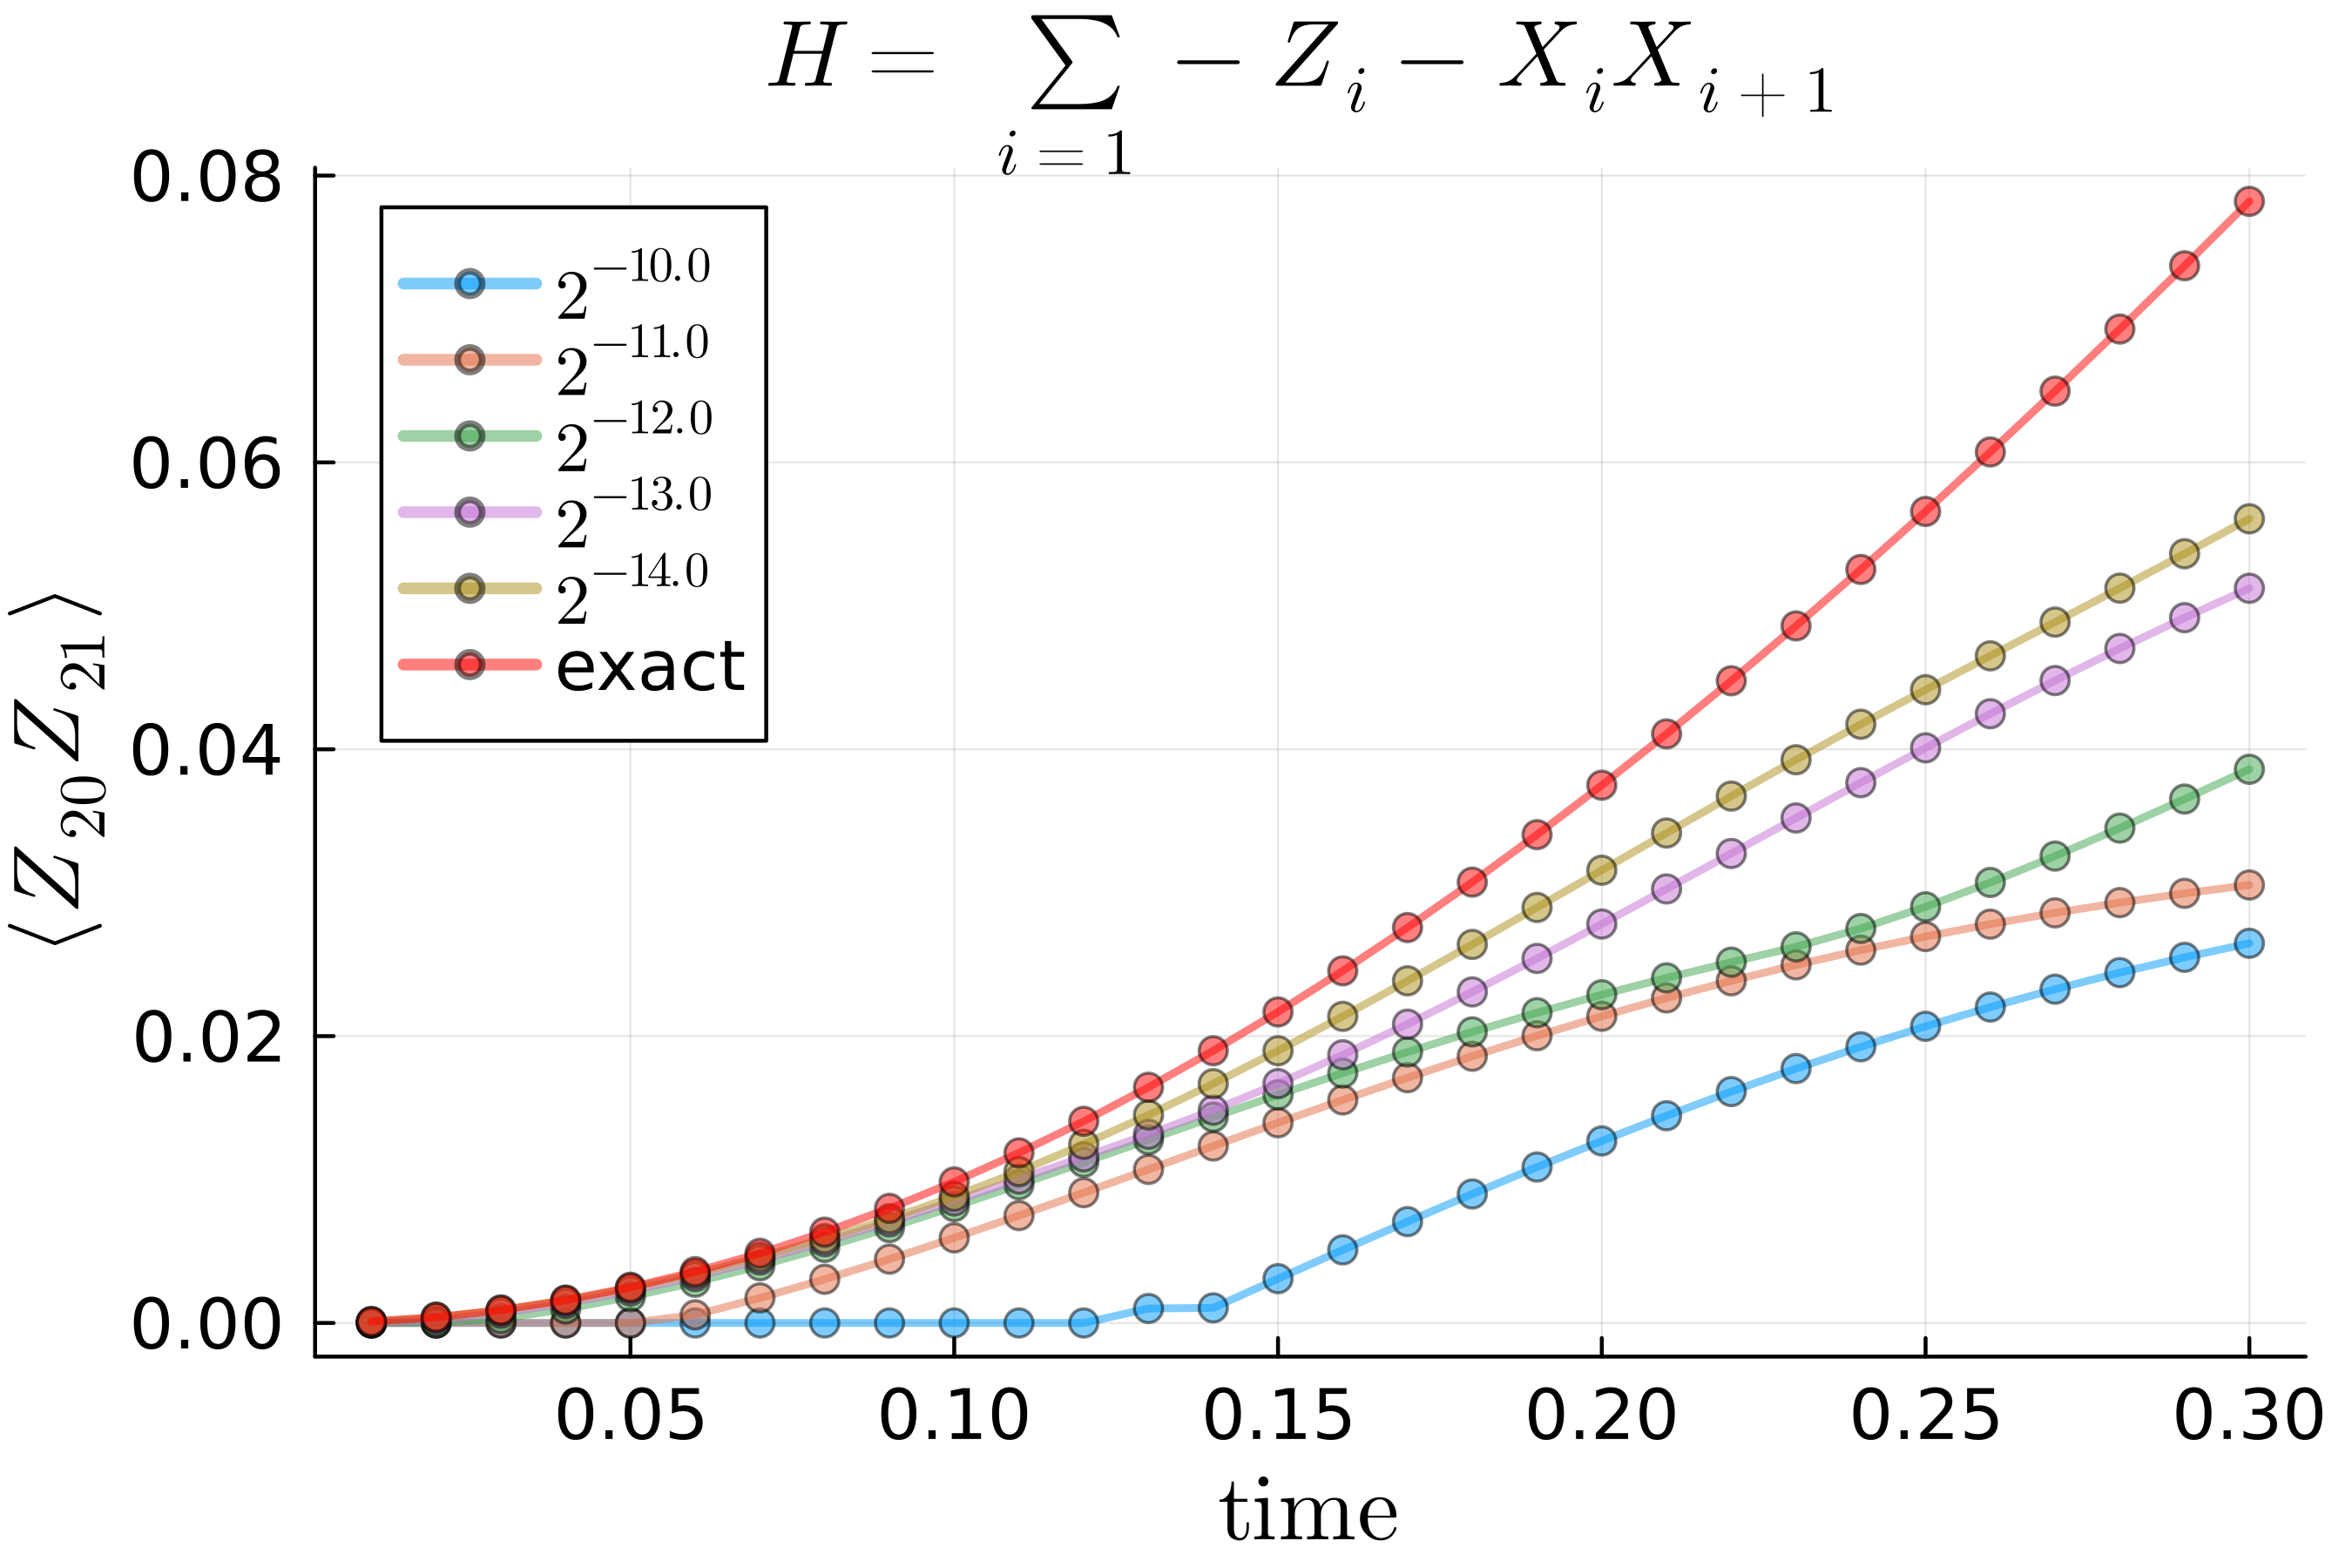

expvals_t: [1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 9.99933337110914e-5]
terms_nbr_t: [60.0, 60.0, 60.0, 60.0, 1713.0]
[SubInfo] init log‐fit params [-9.210407037088338, 0.001]
[SubInfo] fit results: A=9.99933337110914e-5, B=0.00010303858408760051, C=0.0004999999999988049
expvals_t: [1.0e-16, 1.0e-16, 1.0e-16, 0.0001991816029934167, 0.00039868525535552847]
terms_nbr_t: [60.0, 60.0, 60.0, 1713.0, 1713.0]
[SubInfo] init log‐fit params [-7.827338286063095, 0.001]
[SubInfo] fit results: A=0.00039868525535552847, B=0.0004088312873457414, C=0.00041883831104618766
expvals_t: [1.0e-16, 1.0e-16, 0.00029642939904182955, 0.0006915330879369289, 0.0008915257150859551]
terms_nbr_t: [60.0, 60.0, 1713.0, 1713.0, 1713.0]
[SubInfo] init log‐fit params [-7.022576276336918, 0.001]
[SubInfo] fit results: A=0.0008915257150859551, B=0.0009227851557494572, C=0.0005743692680797323
expvals_t: [1.0e-16, 1.0e-16, 0.0009753882133803827, 0.001369140431338727, 0.0015704259233470356]
terms_nbr_t: [60.0, 60.0, 1713.0, 171

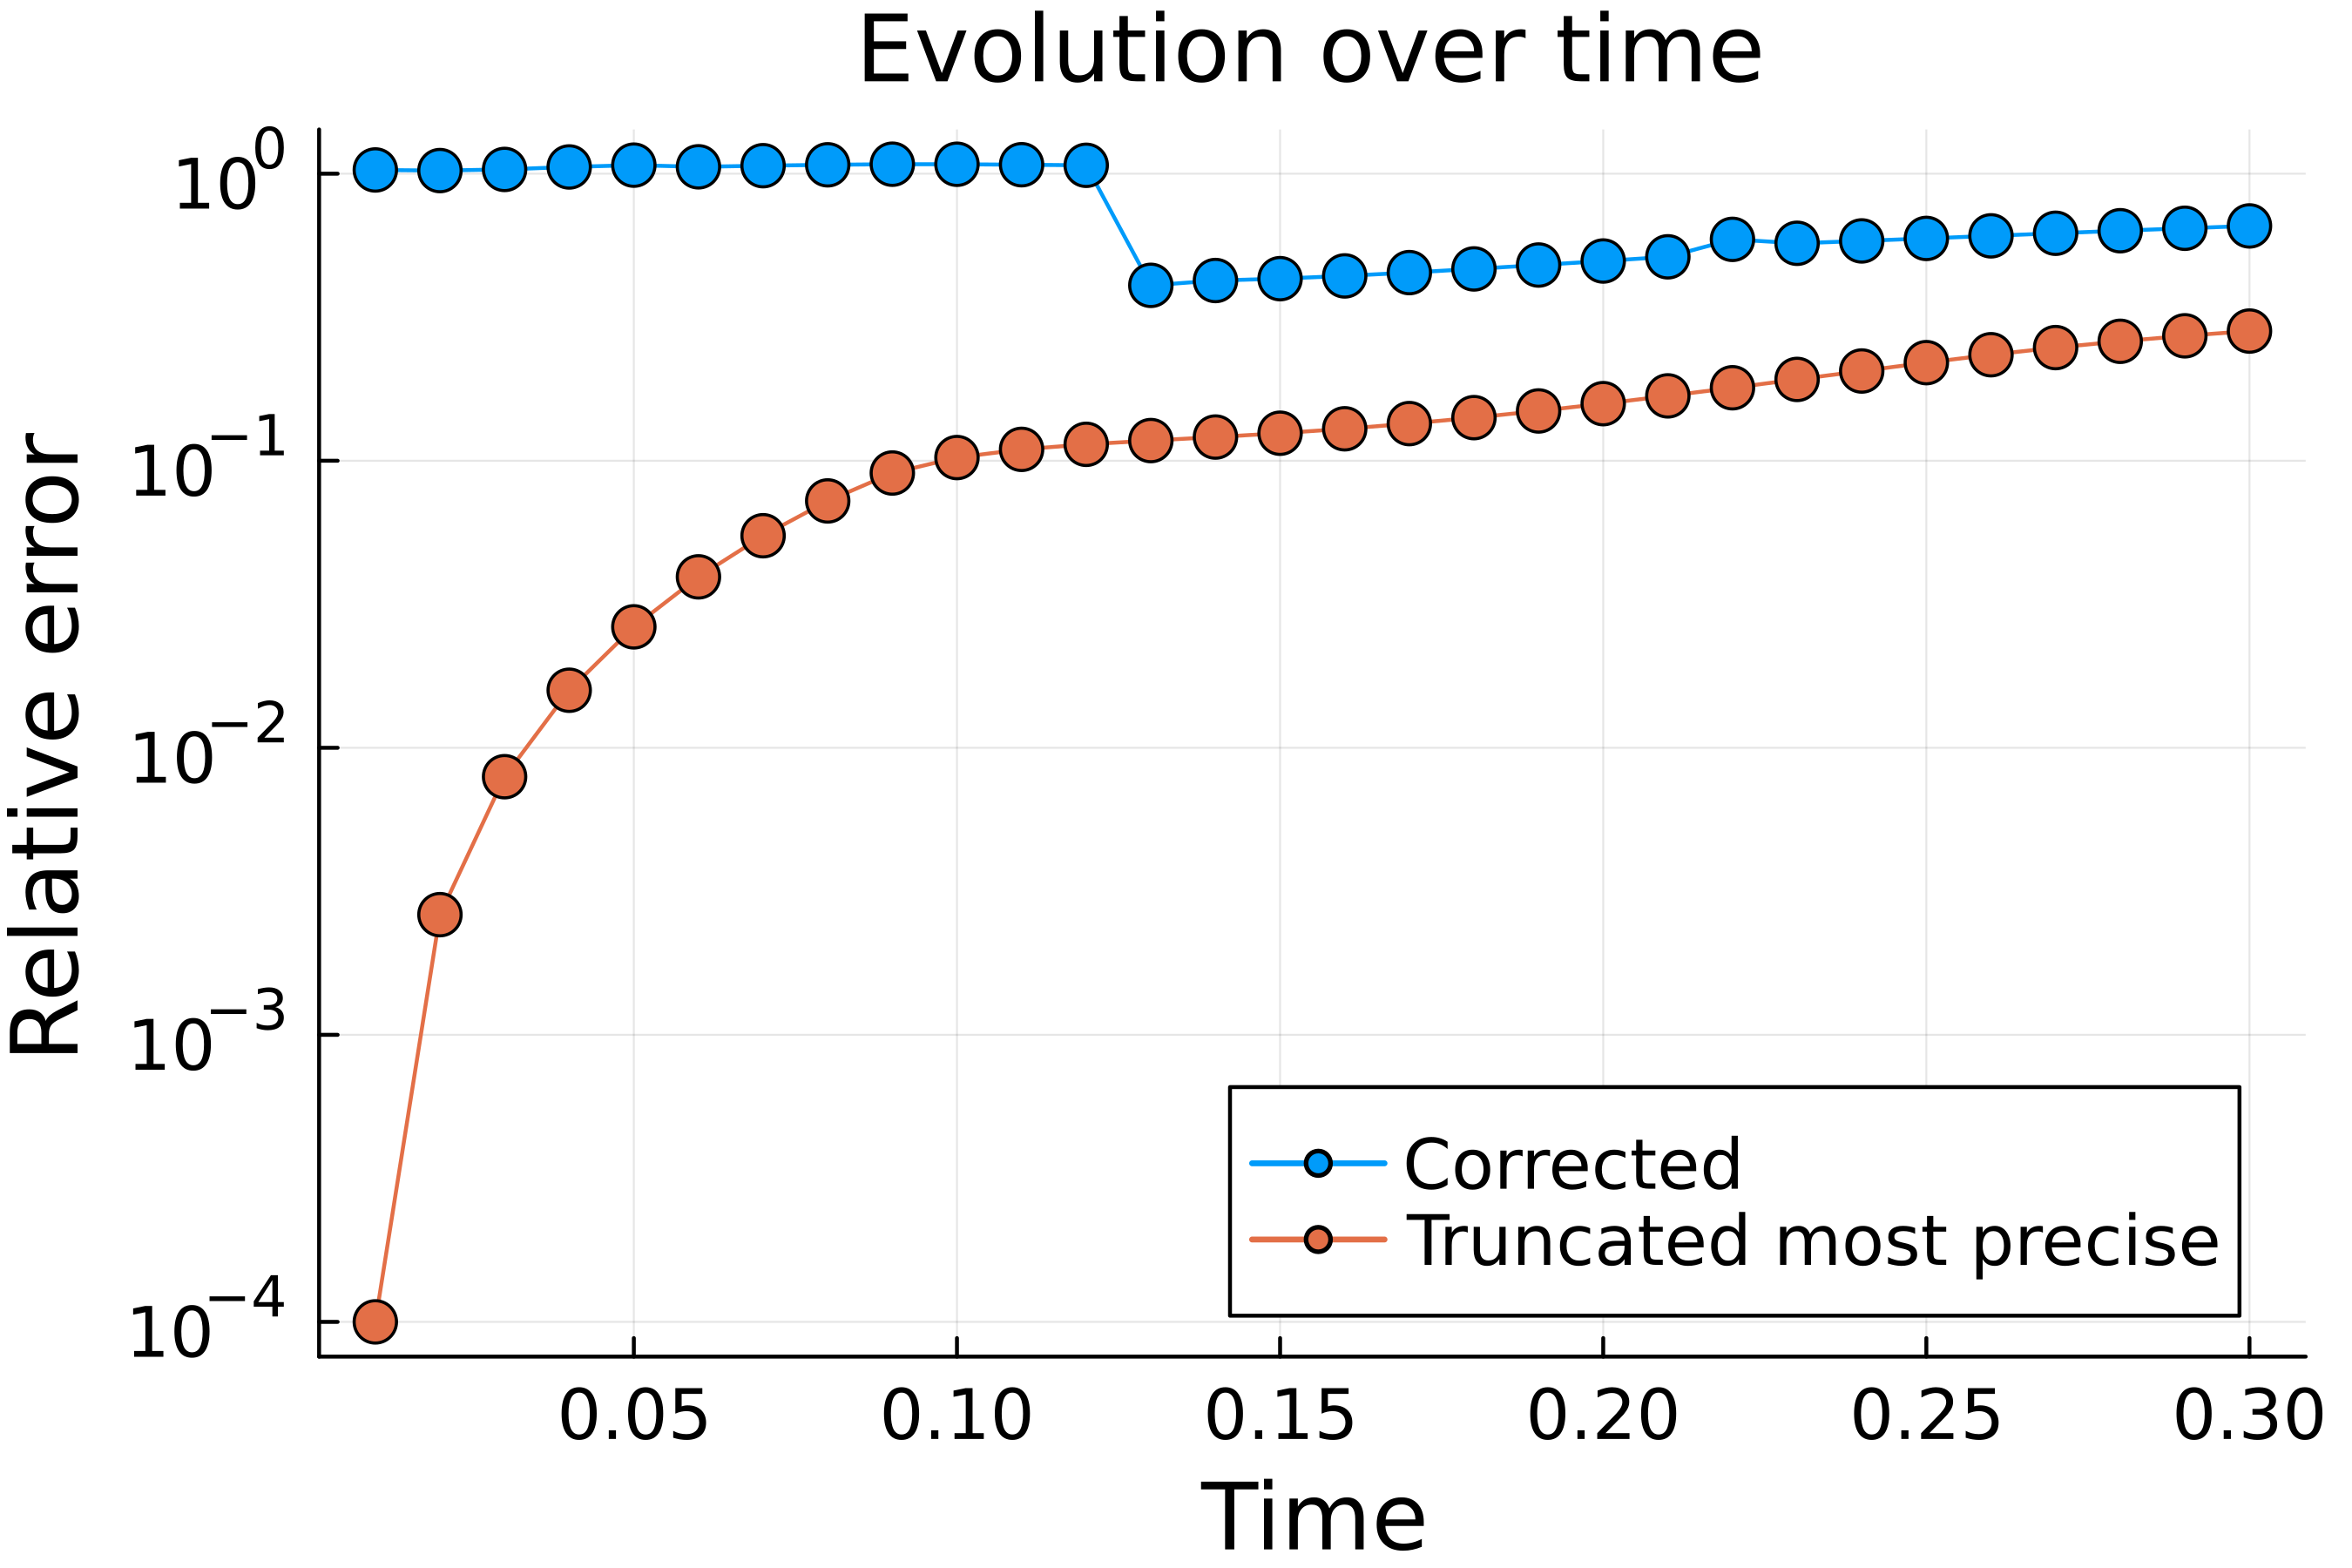

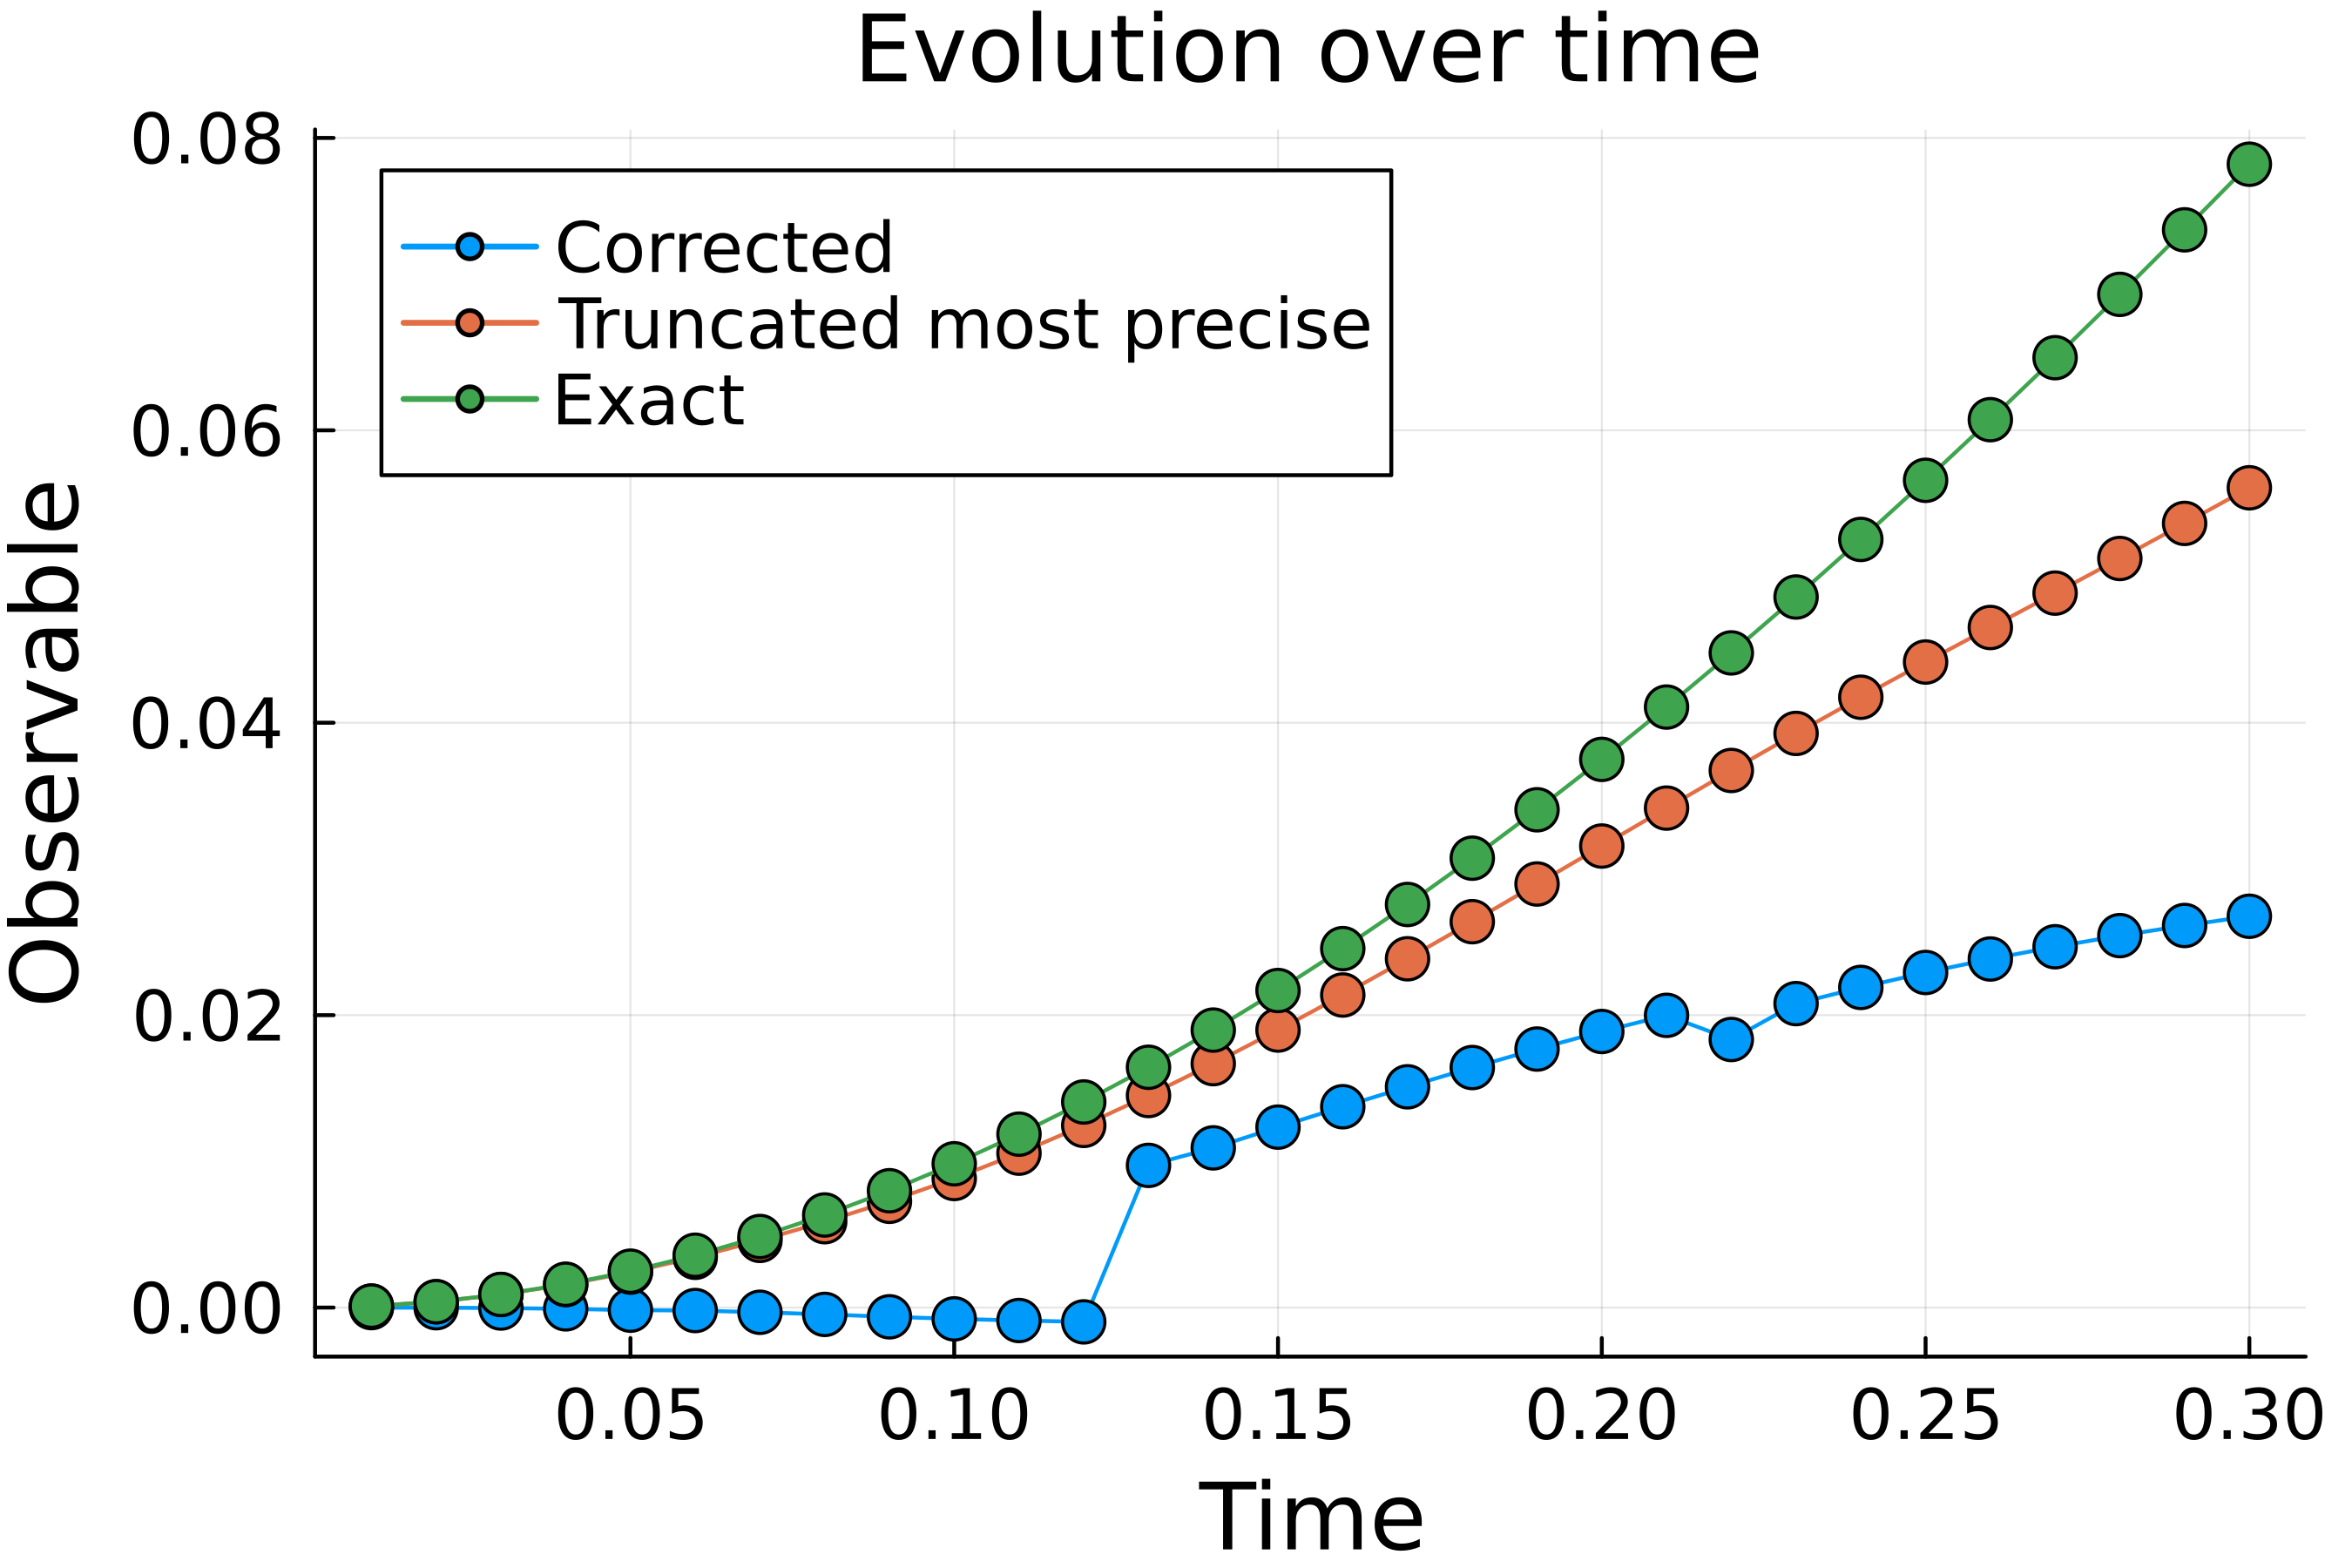

In [6]:
model = "TFIM"
nq = 30
nl = 30
theta = 0.01im
θ = theta

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 12
max_weight = 12
# range -10 to -20 is already generated for nl=20, nq=30
#trunc_coeffs = 2.0 .^ (-10:-1:-20)
trunc_coeffs = 2.0 .^ (-10:-1:-14) # for nq=8, nl=4, tstep=0.01
tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\textrm{time}", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$",guidefontsize=16,
tickfontsize=12,
legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450)

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0) # nq, Jx,Jy, h
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
terms_nbrs = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation, terms_nbr = run_or_read("TFIM",circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation[expectation .== 0] .= 1e-16
    
    #plot last 5 values
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
    push!(terms_nbrs, terms_nbr)
end
#plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
savefig("presentation/$fn.png")	
#delete the first n values of every nested vector in expvals and terms_nbrs
zte_exp(expvals, terms_nbrs, time; exact_expvals=zz, fn=fn);

### J=3.0, h=1.0 -XX-Z Hamiltonian

With the log data fit this works quite well, but we still can't get below the truncated most precise values if we want a good fit.

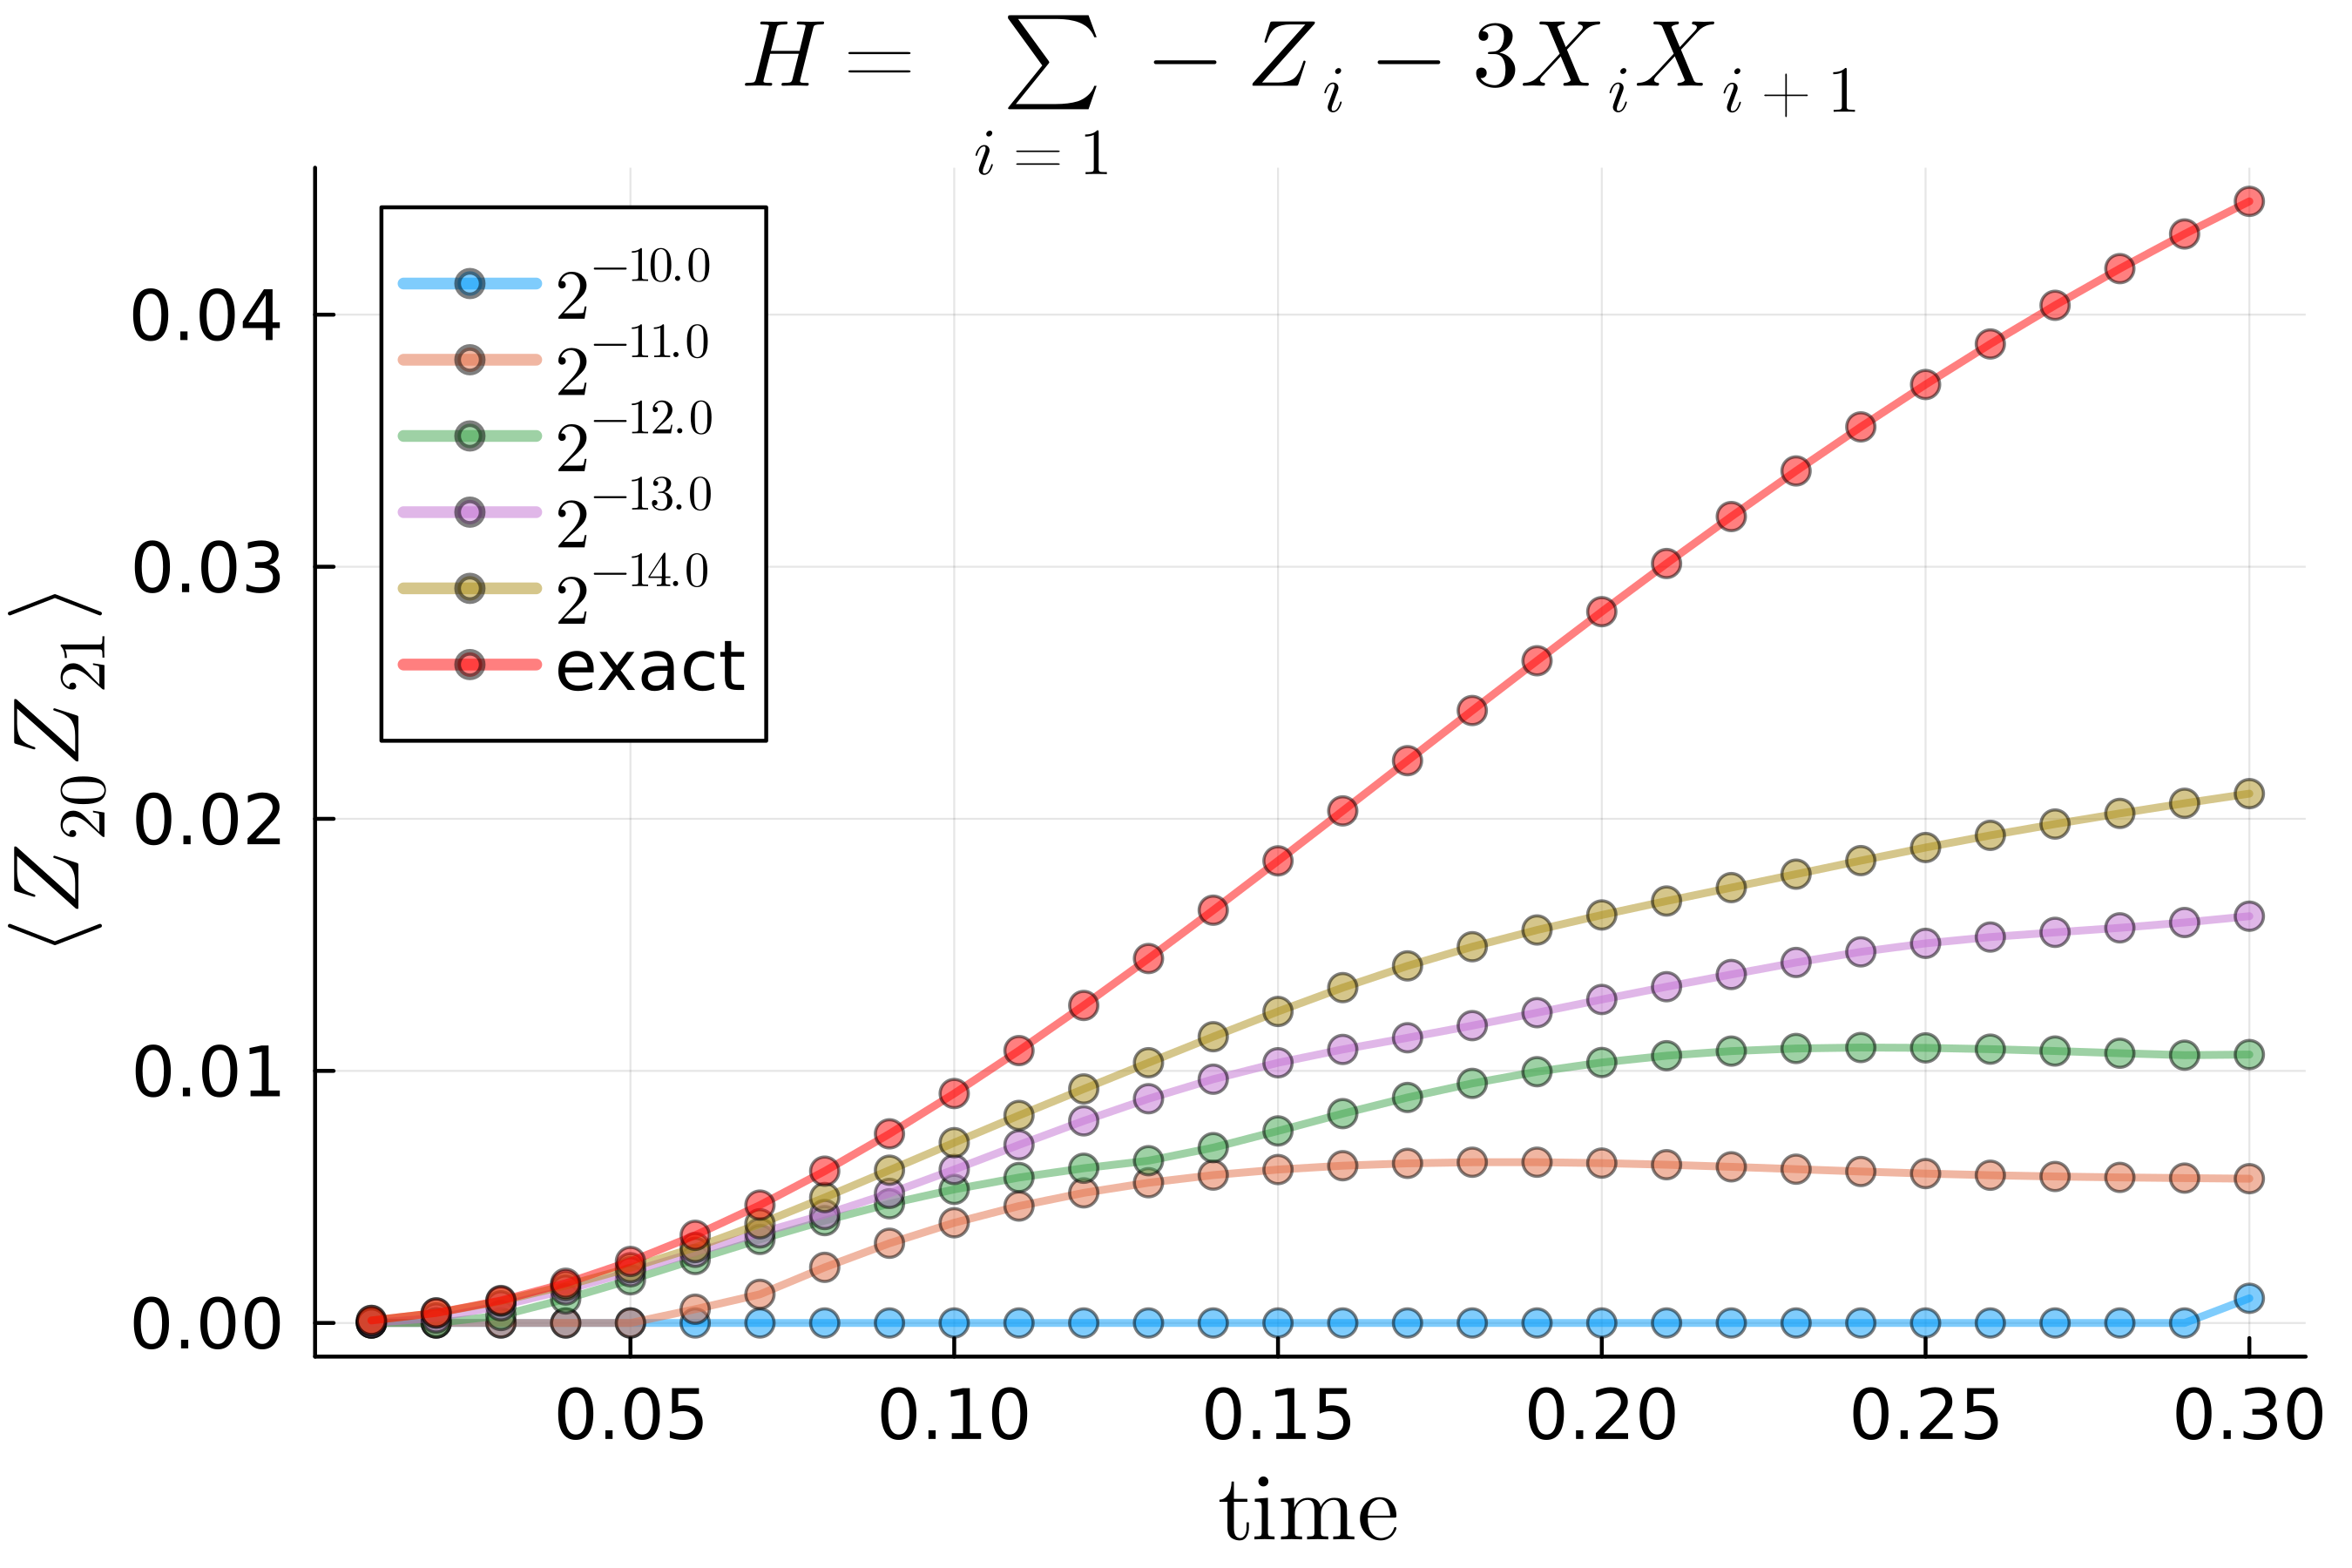

expvals_t: [1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 9.999333371109146e-5]
terms_nbr_t: [60.0, 466.0, 1278.0, 1278.0, 1713.0]
[SubInfo] exp fit params: A=2.499833344663771e-5, B=0.010111162660002357, C=0.10004310241598431
expvals_t: [1.0e-16, 1.0e-16, 1.0e-16, 0.00019918363134028023, 0.00039579810777346056]
terms_nbr_t: [466.0, 1278.0, 1278.0, 1713.0, 5367.0]
[SubInfo] exp fit params: A=0.0008353107988182062, B=0.0009267867468546731, C=0.00014049119254664345
expvals_t: [1.0e-16, 1.0e-16, 0.0002964167895707394, 0.0006813997047088418, 0.0008679831407460669]
terms_nbr_t: [466.0, 1278.0, 1713.0, 5367.0, 15979.0]
[SubInfo] exp fit params: A=0.0008909072358277737, B=0.0010805861763284101, C=0.0002841994354161517
expvals_t: [1.0e-16, 1.0e-16, 0.0009531814406277242, 0.001308217599031692, 0.0014815795088185314]
terms_nbr_t: [1278.0, 1278.0, 5367.0, 15979.0, 15979.0]
[SubInfo] exp fit params: A=0.0014210823770064902, B=0.0020109987268111186, C=0.0002716843967857537
expvals_t: [1.0e-16, 1.0e-16, 0.001

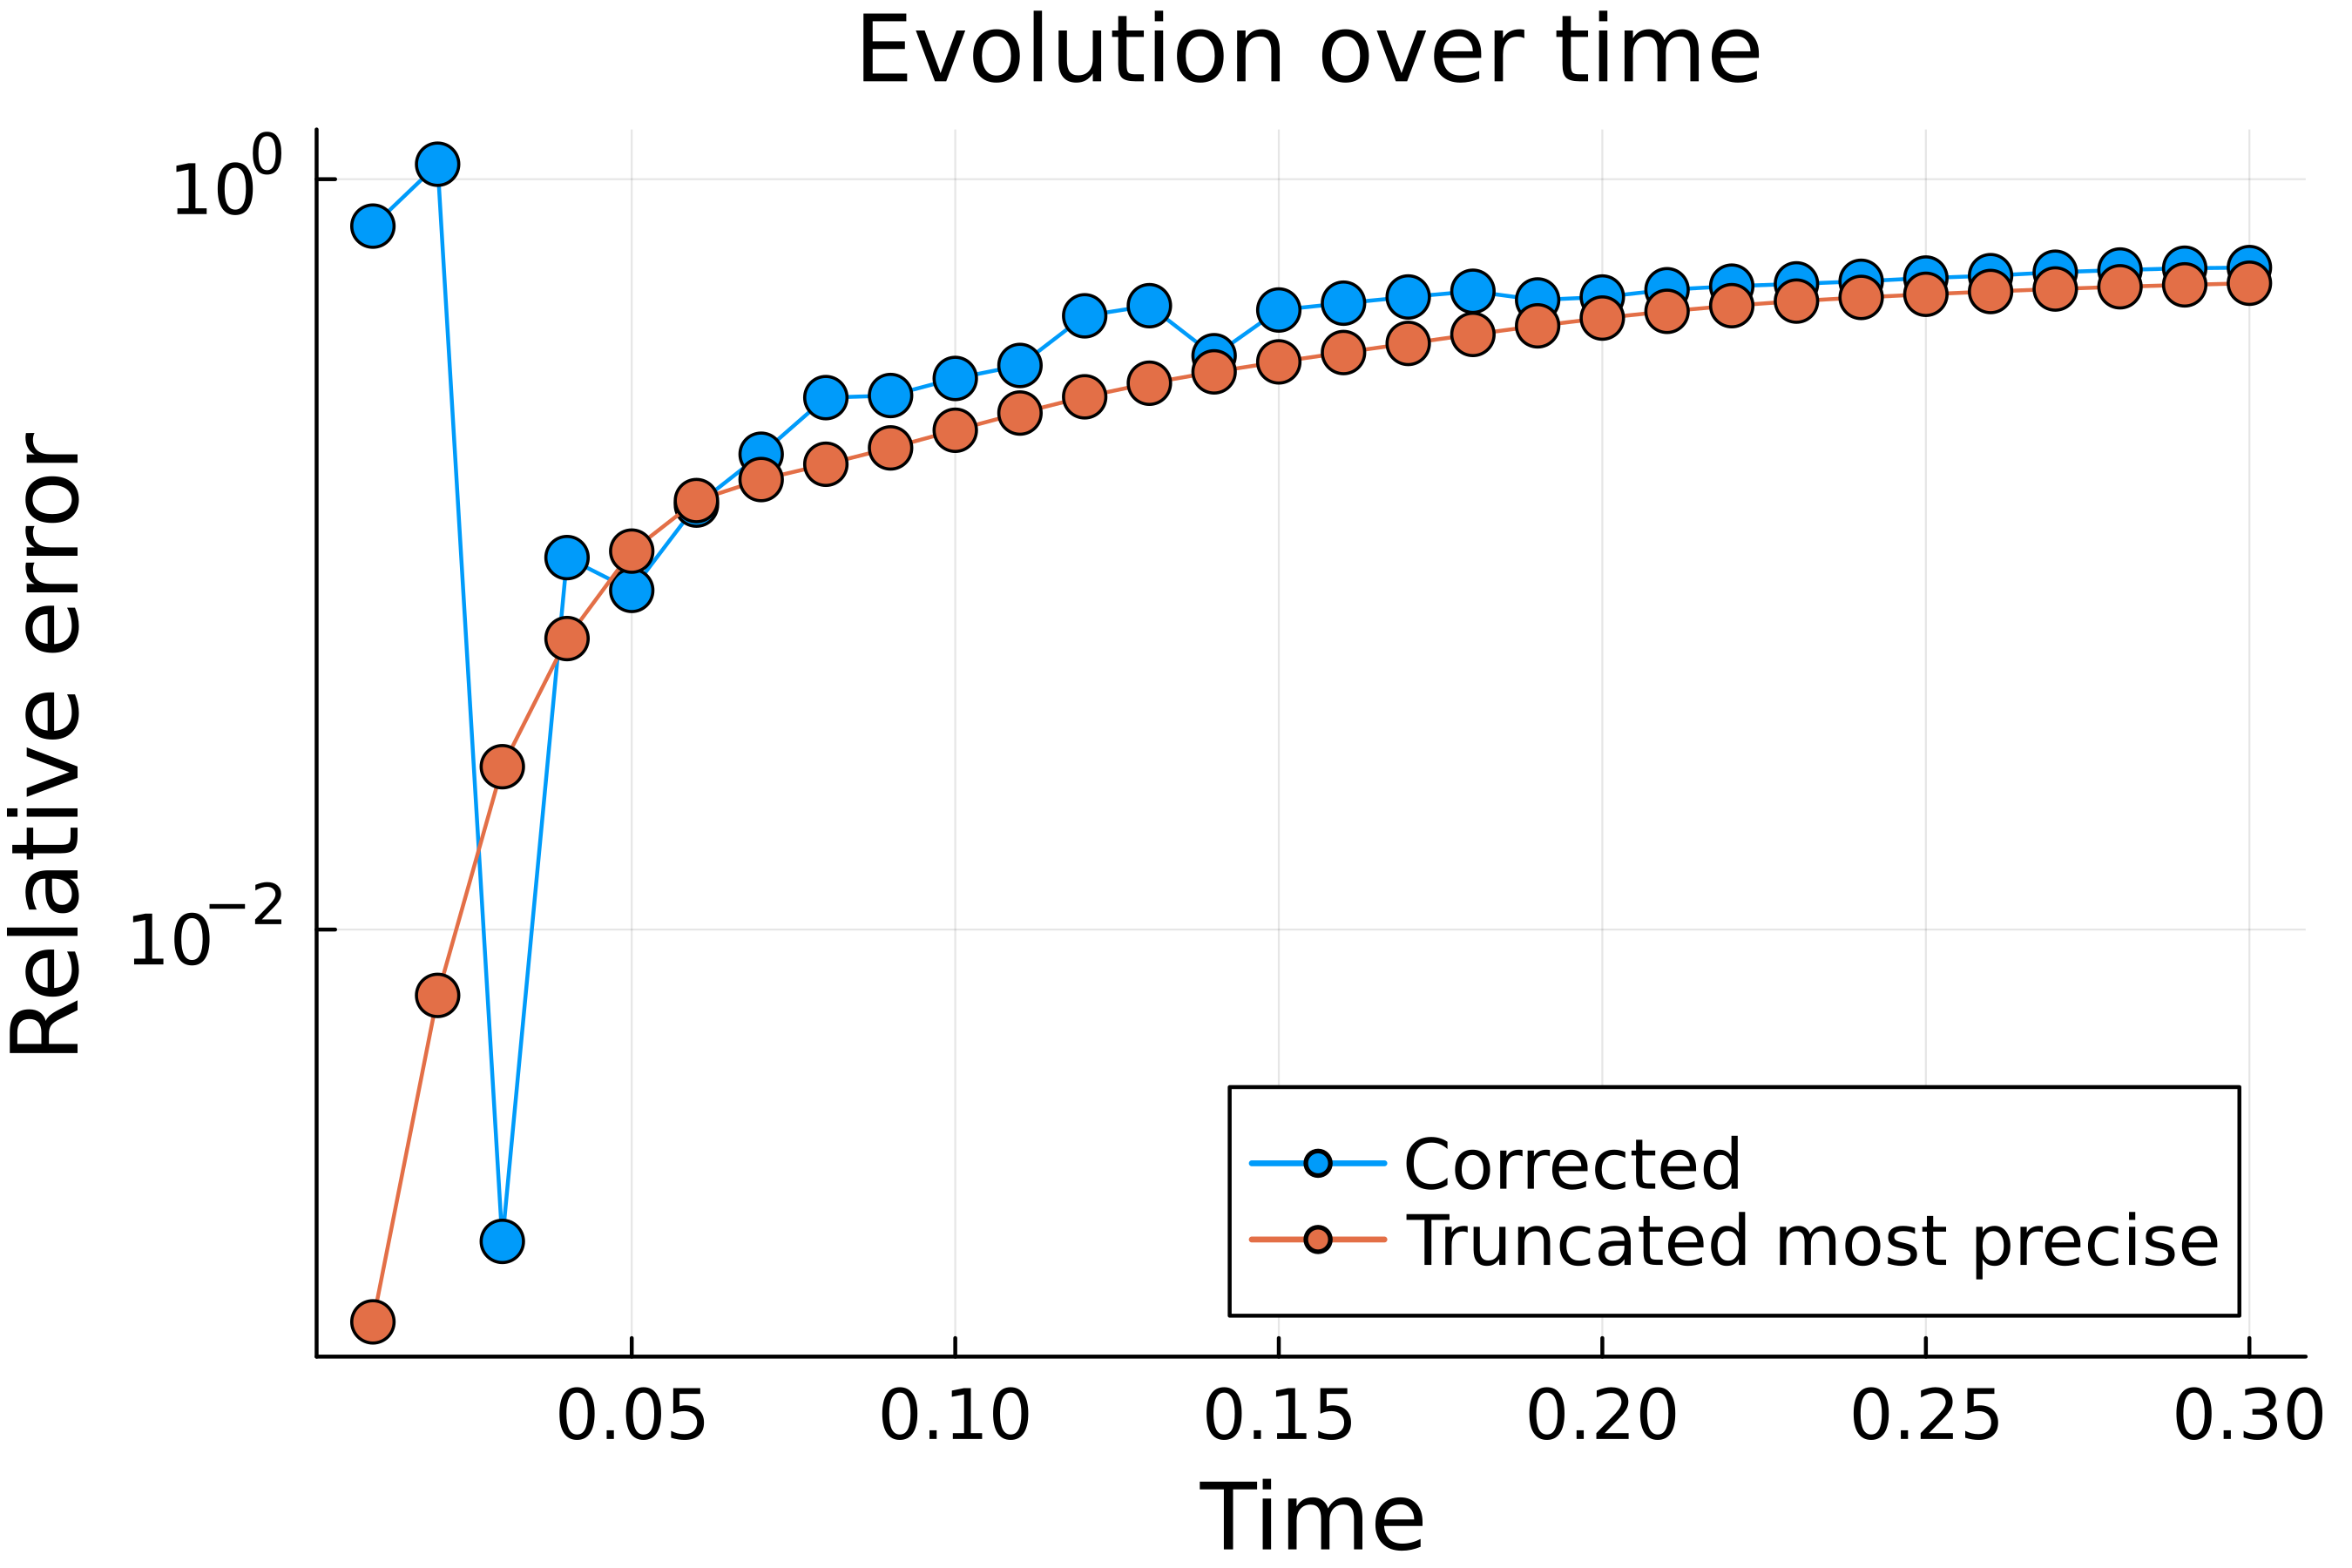

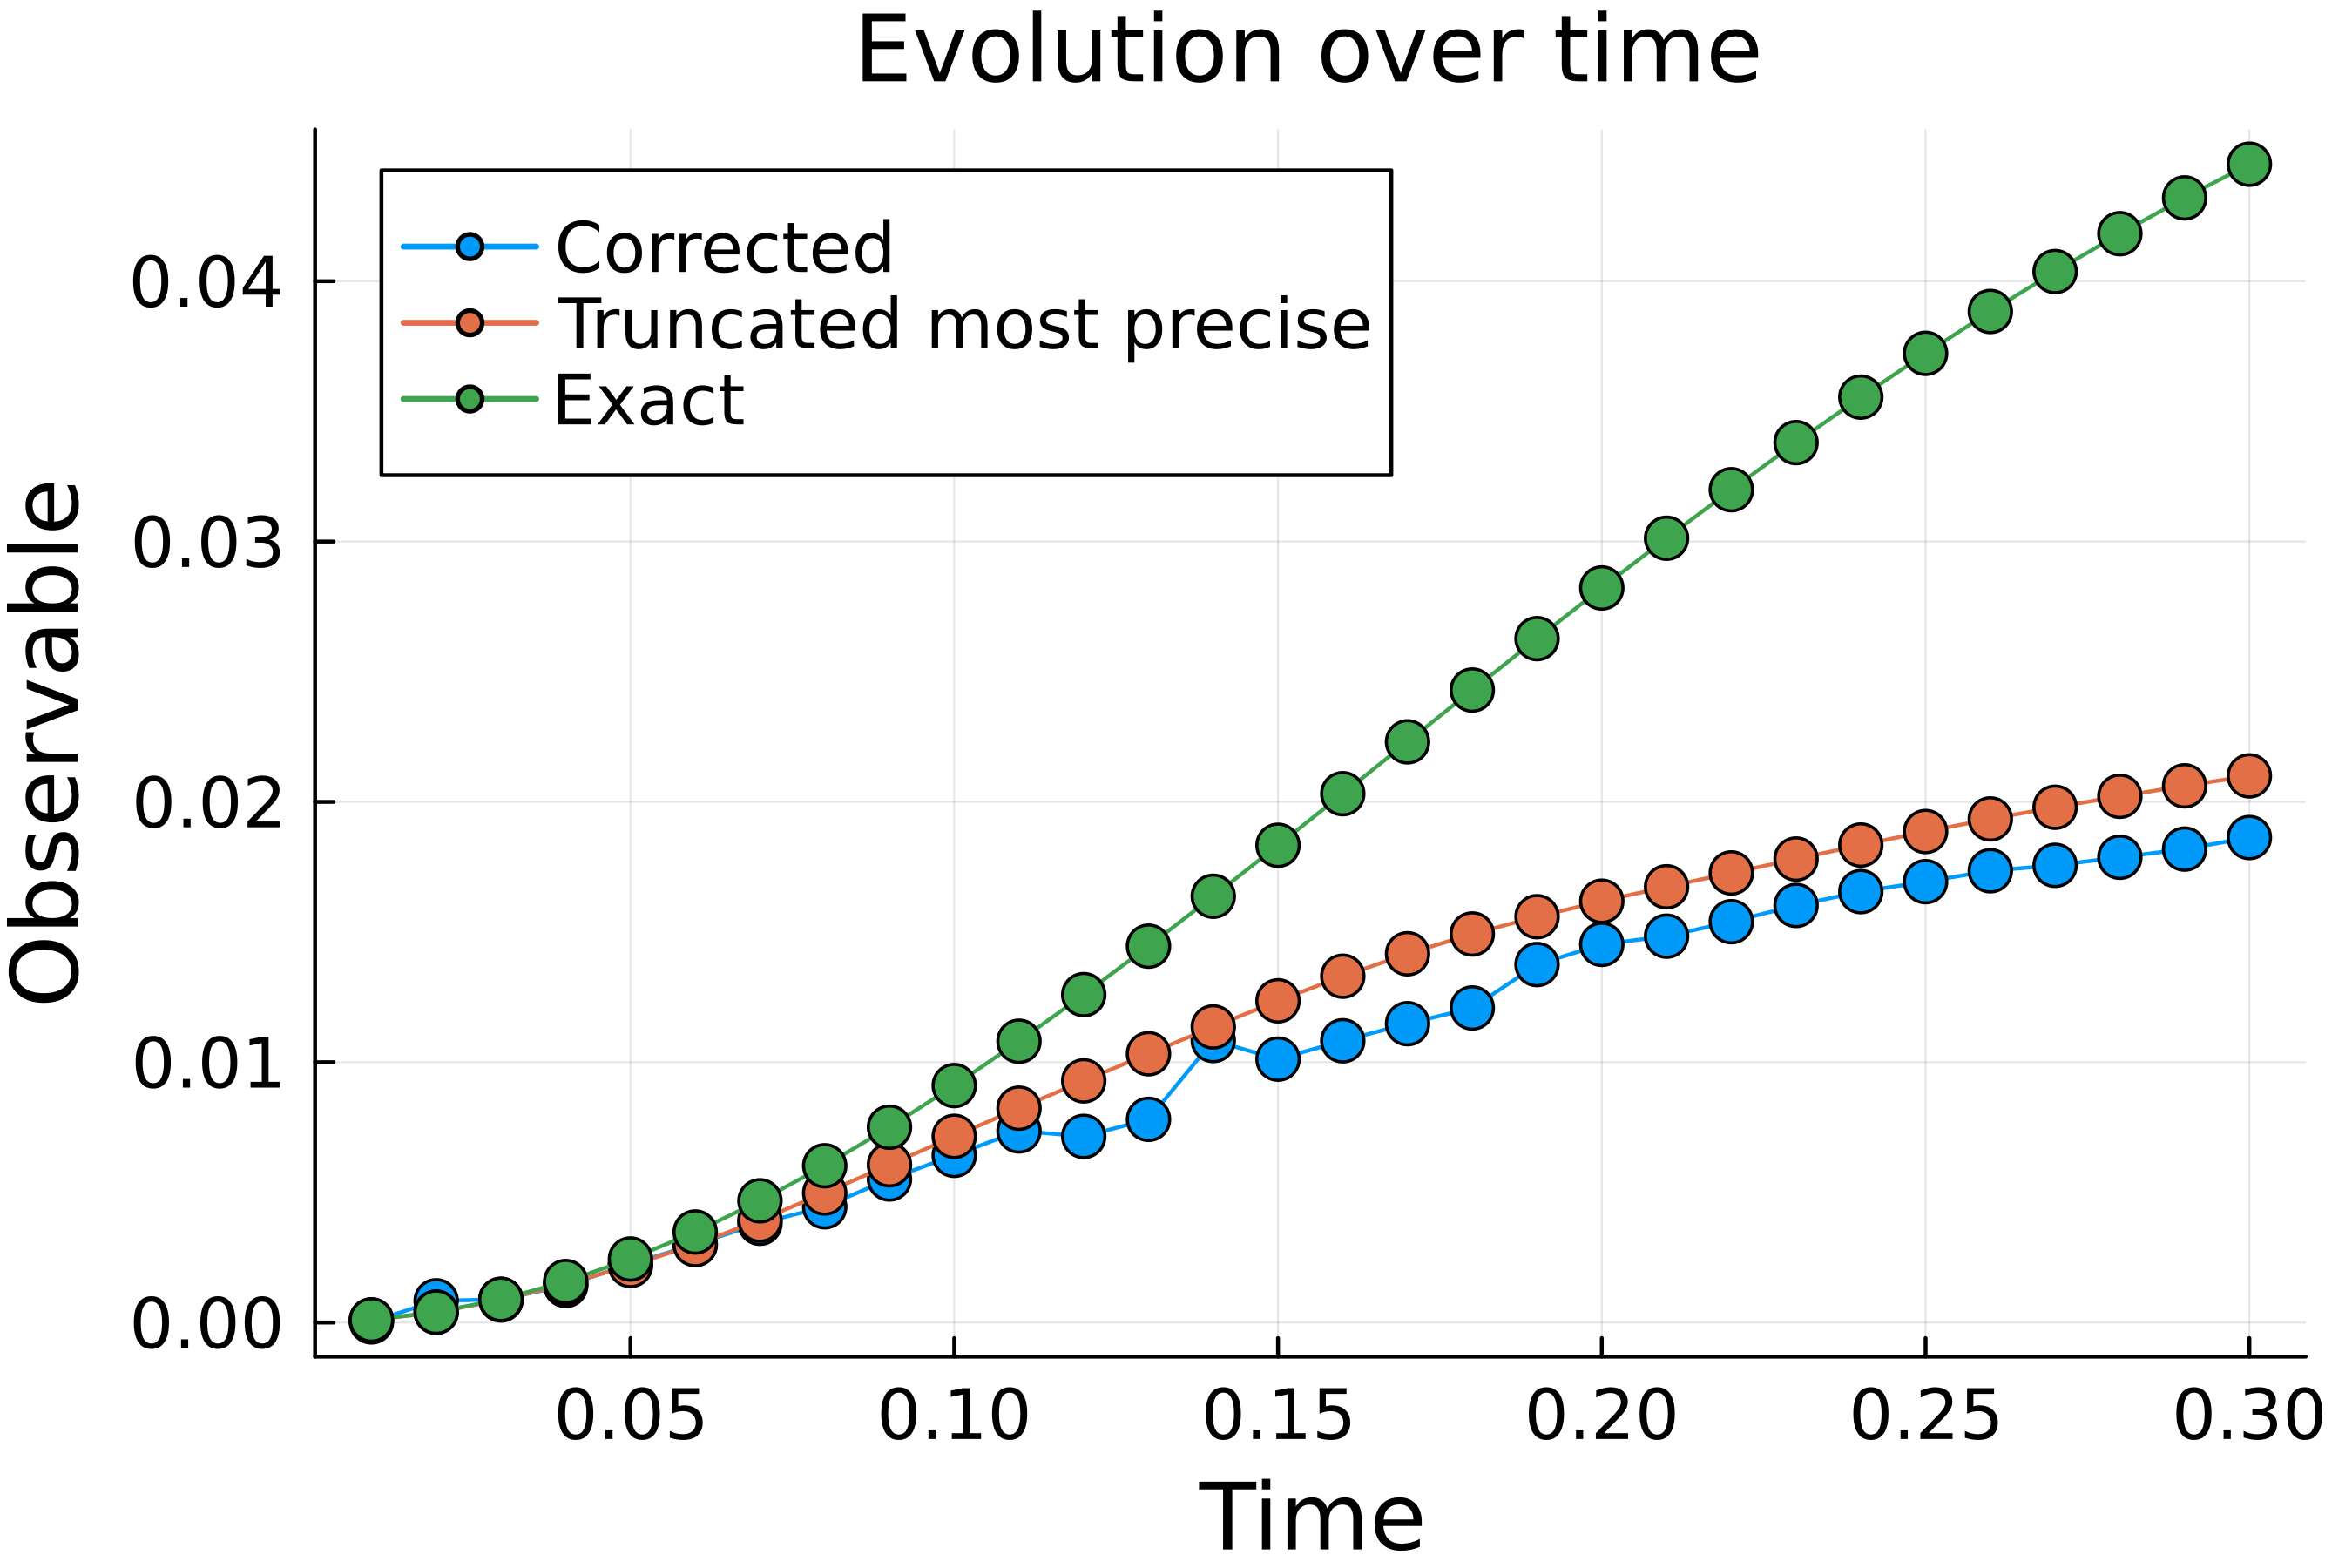

In [30]:
model = "XXZ_J=3.0"
nq = 30
nl = 30
theta = 0.01im
θ = theta
J = 3.0
h = 1.0
topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
append!(circuitTFIM, PauliRotation(:Z, ii, h*θ) for ii in 1:nq);
append!(circuitTFIM, PauliRotation([:X, :X], pair, J*θ) for pair in topology);

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 12
max_weight = 12
# range -10 to -20 is already generated for nl=20, nq=30
#trunc_coeffs = 2.0 .^ (-10:-1:-20)
trunc_coeffs = 2.0 .^ (-10:-1:-14) # for nq=8, nl=4, tstep=0.01
tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\textrm{time}", title = L"$H = \sum_{i=1} -Z_i - 3 X_iX_{i+1}$",guidefontsize=16,
tickfontsize=12,
legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450)

# exact expectation values calculations
M = jordan_wigner_tfim(nq, J, 0.0, h) # nq, Jx,Jy, h
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
terms_nbrs = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation, terms_nbr = run_or_read(model,circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation[expectation .== 0] .= 1e-16
    
    #plot last 5 values
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
    push!(terms_nbrs, terms_nbr)
end
#plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
savefig("presentation/$fn.png")	
#delete the first n values of every nested vector in expvals and terms_nbrs
zte_exp(expvals, terms_nbrs, time; exact_expvals=zz, fn=fn);

# Check out the exp fit isolated
- fit looks correct, but should give us a different prediction


In [ ]:
function zte_exp(expvals, terms_nbr, times; plotting=true, exact_expvals=nothing, abs_threshold=1e-16, fn="")
        try
        @assert length(expvals)==length(terms_nbr)
    catch e
        error("The length of input arguments don't match (length(expvals)=$(length(expvals)), length(terms_nbr)=$(length(terms_nbr)))")
    end
    corrected_expvals = Vector{Float64}()
    for idx=1:length(expvals[1])
        expvals_t = [row[idx] for row in expvals]
        terms_nbr_t = [row[idx] for row in terms_nbr]
        println("expvals_t: ", expvals_t)
        println("terms_nbr_t: ", terms_nbr_t)

        # data = DataFrame(trunc=terms_nbr, expval=expvals_t)
        push!(corrected_expvals, exp_fit_2(terms_nbr_t, expvals_t; abs_threshold=abs_threshold, fn="plot_fits/"*fn*"_step=$idx.png"))
    end

    @logmsg SubInfo "corrected_expvals: $corrected_expvals"

    if plotting
        truncated_most_precise = expvals[end]
        try
            @assert length(times)==length(corrected_expvals)==length(truncated_most_precise)
        catch e
            error("The lengths don't match for plotting (length(times)=$(length(times)), length(corrected_expvals)=$(length(corrected_expvals)))")
        end
        corrected_expvals_cleaned = replace_zeros(corrected_expvals)
        truncated_most_precise_cleaned = replace_zeros(truncated_most_precise)
        p = plot(times, corrected_expvals_cleaned, label="Corrected", marker=:circle, ms = 6)
        plot!(times, truncated_most_precise_cleaned, label="Truncated most precise", marker=:circle, guidefontsize=16, tickfontsize=12, legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450, legend=:topleft)
        # plot!(yscale=:log10)
        if exact_expvals!=nothing 
            plot!(times, exact_expvals, label="Exact", marker=:circle, tickfontsize = 12, ms=6)
        end
        # plot!(yscale=:log10)
    
        xlabel!("Time")
        ylabel!("Observable")
        title!("Evolution over time")
        if exact_expvals!=nothing
            exact_expvals_cleaned = replace_zeros(exact_expvals)
            # plot!(times, exact_expvals_cleaned, label="exact", marker=:circle)
            rel_err_corr = replace_zeros(abs.((corrected_expvals-exact_expvals)./exact_expvals))
            q = plot(times, rel_err_corr, label="Corrected", marker=:circle, tickfontsize = 12, ms=6)
            rel_err_most_prec = replace_zeros(abs.((truncated_most_precise-exact_expvals)./exact_expvals))
            plot!(times, rel_err_most_prec, label="Truncated most precise", marker=:circle, guidefontsize=16, tickfontsize=12, legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450, legend=:bottomright)

            plot!(yscale=:log10)
            xlabel!("Time")
            ylabel!("Relative error")
            title!("Evolution over time")
            display(q)
        end
        display(p)
    end
    return corrected_expvals
end

function exp_fit_3(xdata, ydata; abs_threshold=1e-16, fn="")
    # 0) mask small x
    mask = xdata .>= abs_threshold
    x = xdata[mask]; y = ydata[mask]

    # 1) determine scale S from smallest x’s order of magnitude
    S = 10.0 ^ floor(Int, log10(minimum(x)))
    x_scaled = x ./ S

    # 2) model in scaled units: y = A − B exp(−C' x_scaled)
    model(x, p) = p[1] .- p[2] .* exp.(-p[3] .* x)

    # 3) initial guesses A₀≈y[end], B₀≈A₀−y[1], C'₀≈1
    p0 = [y[end], y[end] - y[1], 1.0]

    # 4) define weights ∝ x to emphasize plateau region
    w = x_scaled ./ maximum(x_scaled)

    # 5) perform weighted fit
    fit = curve_fit(model, x_scaled, y, p0; weights = w)
    A_fit, B_fit, Cp_fit = fit.param

    # recover physical decay constant C = C'/S
    C_fit = Cp_fit / S

    # 6) build fit curve on original scale
    x_fit = range(minimum(x), stop=maximum(x), length=200)
    y_fit = A_fit .- B_fit .* exp.(-C_fit .* x_fit)

    @logmsg SubInfo "exp fit params: A=$A_fit, B=$B_fit, C=$C_fit"

    if fn != ""
        scatter(x, y; label="data", marker=:circle, ms=6, xscale=:log10)
        plot!(x_fit, y_fit; label="fit", lw=2)
        plot!(xscale=:log10)
        xlabel!("Number of Pauli Strings"); ylabel!("Expectation Value")
        savefig(fn)
    end

    return A_fit
end

function exp_fit_2(xdata, ydata; abs_threshold=1e-16, fn="")
    
    # 0) mask small x as before
    mask = xdata .>= abs_threshold
    x = xdata[mask]; y = ydata[mask]

    # 1) determine scale S from smallest x’s order of magnitude
    S = 10.0 ^ floor(Int, log10(minimum(x)))
    x_scaled = x ./ S

    # 2) define model in scaled units: y = A − B exp(−C' x_scaled)
    model(x, p) = p[1] .- p[2] .* exp.(-p[3] .* x)

    # 3) initial guesses A₀≈y[end], B₀≈A₀−y[1], C'₀≈1
    p0 = [y[end], y[end] - y[1], 1.0]

    # 4) perform fit
    fit = curve_fit(model, x_scaled, y, p0)
    A_fit, B_fit, Cp_fit = fit.param

    # recover physical decay constant C = C'/S
    C_fit = Cp_fit / S

    # 5) build fit curve back on original scale
    x_fit = range(minimum(x), stop=maximum(x), length=100)
    y_fit = A_fit .- B_fit .* exp.(-C_fit .* x_fit)

    @logmsg SubInfo "exp fit params: A=$A_fit, B=$B_fit, C=$C_fit"
    if fn != ""
    scatter(x, y, label="data", marker=:circle, ms=6)
    array = range(minimum(x), maximum(x), 50)
    plot!(x_fit, y_fit, label="fit", 
        guidefontsize=16, tickfontsize=12, legendfontsize=12, titlefontsize = 16, ms = 6)
    if minimum(x) < 1; plot!(xscale=:log10); end
    title = match(r"step=\d+", fn)
    xlabel!("Number of Pauli Strings"); ylabel!("Expectation Value")
    savefig(fn)
    end
    return A_fit
end


function exp_fit(xdata, ydata; abs_threshold=1e-16, fn="")

        # mask small x as before…
    mask = xdata .>= abs_threshold
    x = xdata[mask]; y = ydata[mask]
    y = y/10^6
    # model with free A,B,C
    model(x, p) = p[1] .- p[2] .* exp.(-p[3] .* x)
    #p0 = [y[end], A - y[1], 1e-3]  # initial guesses: [A0, B0, C0]
    p0 = [y[end], y[1] - y[end], 0.01] # initial guess matters!
    fit = curve_fit(model, x, y, p0)

    A_fit, B_fit, C_fit = fit.param
    y_inf = A_fit

    @logmsg SubInfo "exp fit params: A=$A_fit, B=$B_fit, C=$C_fit"
        if fn != ""
        scatter(x, y, label="data", marker=:circle, ms=6)
        array = range(minimum(x), maximum(x), 50)
        plot!(array, A_fit .- B_fit .* exp.(-C_fit .* array), label="fit", 
            guidefontsize=16, tickfontsize=12, legendfontsize=12, titlefontsize = 16, ms = 6)
        if minimum(x) < 1; plot!(xscale=:log10); end
        title = match(r"step=\d+", fn)
        xlabel!("Number of Pauli Strings"); ylabel!("Expectation Value")
        savefig(fn)
        end
    return y_inf
    end


    # mask = xdata .>= abs_threshold
    # xdata = xdata[mask]
    # ydata = ydata[mask]
    # model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    # p0 = [ydata[end], ydata[1] - ydata[end], 0.01] # initial guess matters!
    # @logmsg SubInfo "initial parameters exp fit $p0 "
    # # smaller initial rate
    # fit = curve_fit(model, xdata, ydata, p0)
    # @logmsg SubInfo "exp fit params: $fit.param"
    # if fn!=""
    #     scatter(xdata, ydata, label="data", marker=:circle)
    #     array = range(minimum(xdata), maximum(xdata), 50)
    #     plot!(array, model(array, fit.param), label="fit",guidefontsize=16,
#works but good (working on log of data)

function replace_zeros(vec, val=1e-16)
    vec[abs.(vec).<=val] .= val
    return vec
end

replace_zeros (generic function with 2 methods)

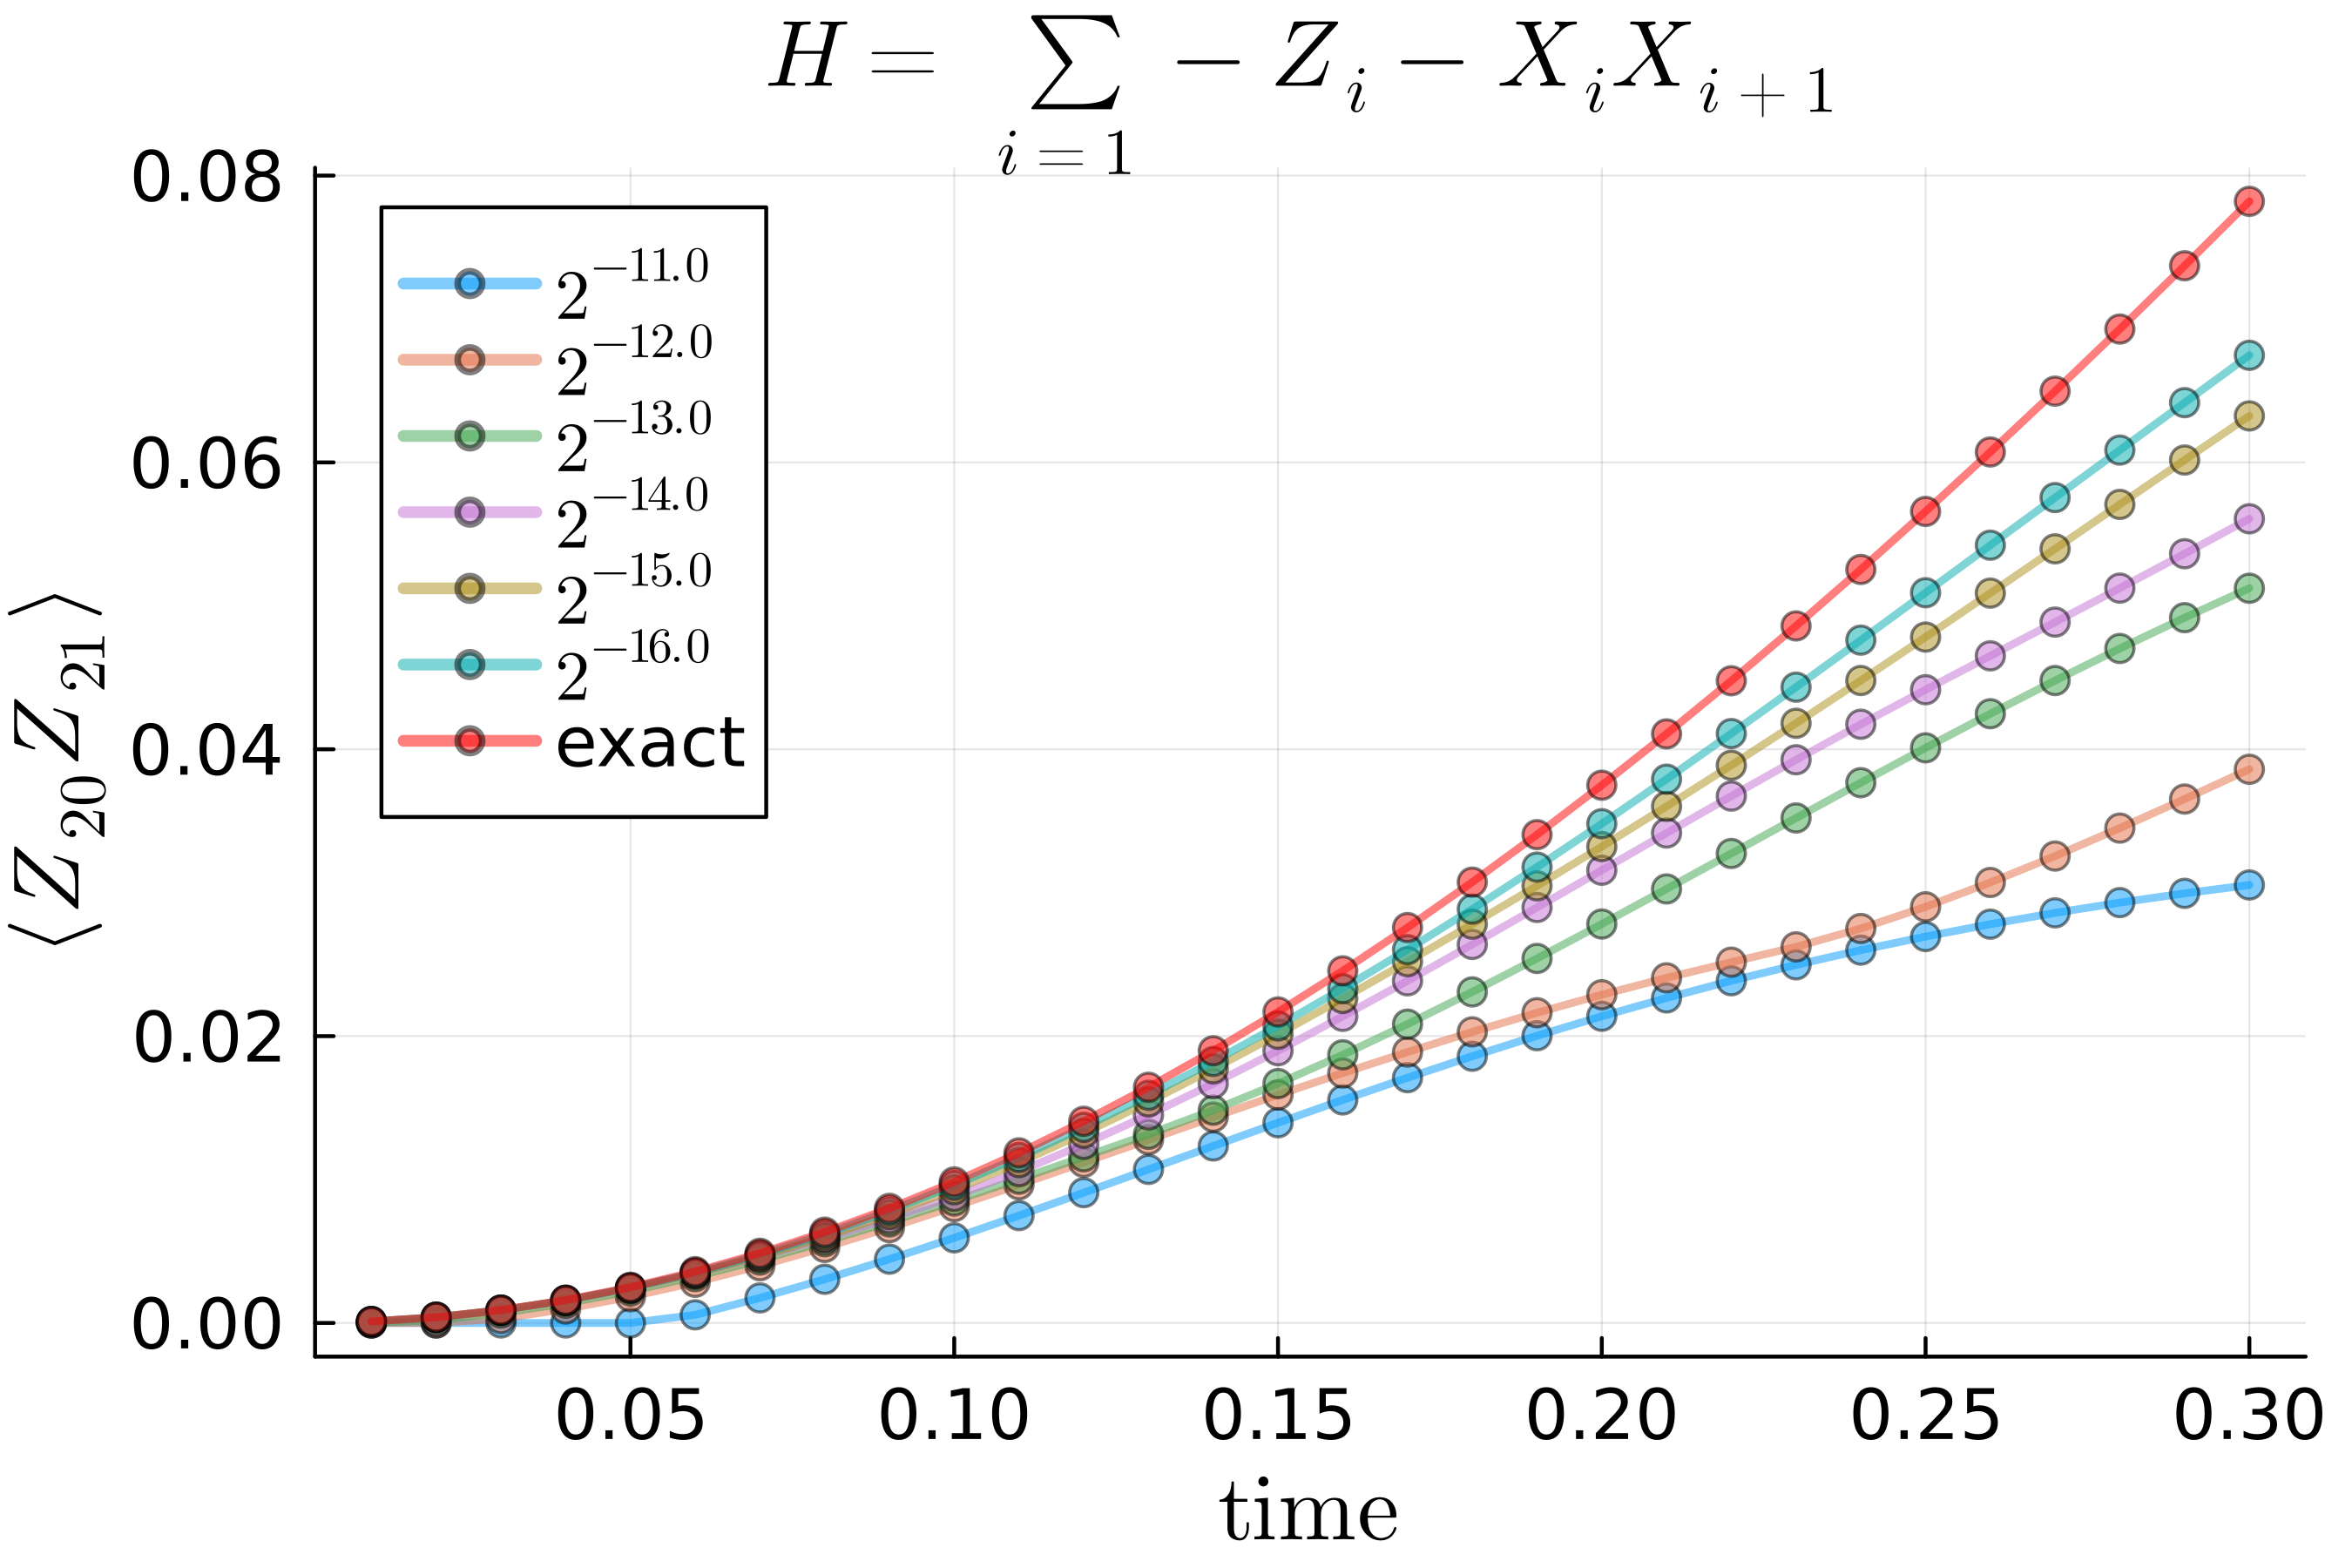

expvals_t: [1.0e-16, 1.0e-16, 1.0e-16, 9.99933337110914e-5, 9.99933337110914e-5, 9.99933337110914e-5]
terms_nbr_t: [60.0, 60.0, 60.0, 1713.0, 1713.0, 1713.0]
[SubInfo] exp fit params: A=9.999333364089562e-5, B=0.0323152793714044, C=0.09630319871468672
expvals_t: [1.0e-16, 1.0e-16, 0.0001991816029934167, 0.00039868525535552847, 0.00039868525535552847, 0.00039868525535552847]
terms_nbr_t: [60.0, 60.0, 1713.0, 1713.0, 1713.0, 1713.0]
[SubInfo] exp fit params: A=0.00034880934225543385, B=0.08349788956910026, C=0.09130085267069357
expvals_t: [1.0e-16, 0.00029642939904182955, 0.0006915330879369289, 0.0008915257150859551, 0.0008915257150859551, 0.0008915257150859551]
terms_nbr_t: [60.0, 1713.0, 1713.0, 1713.0, 1713.0, 1713.0]
[SubInfo] exp fit params: A=0.0007325079264869342, B=0.1357917463017315, C=0.08704005919778719
expvals_t: [1.0e-16, 0.0009753882133803827, 0.001369140431338727, 0.0015704259233470356, 0.0015704259233470356, 0.0015704259233470356]
terms_nbr_t: [60.0, 1713.0, 1713.0, 1713.

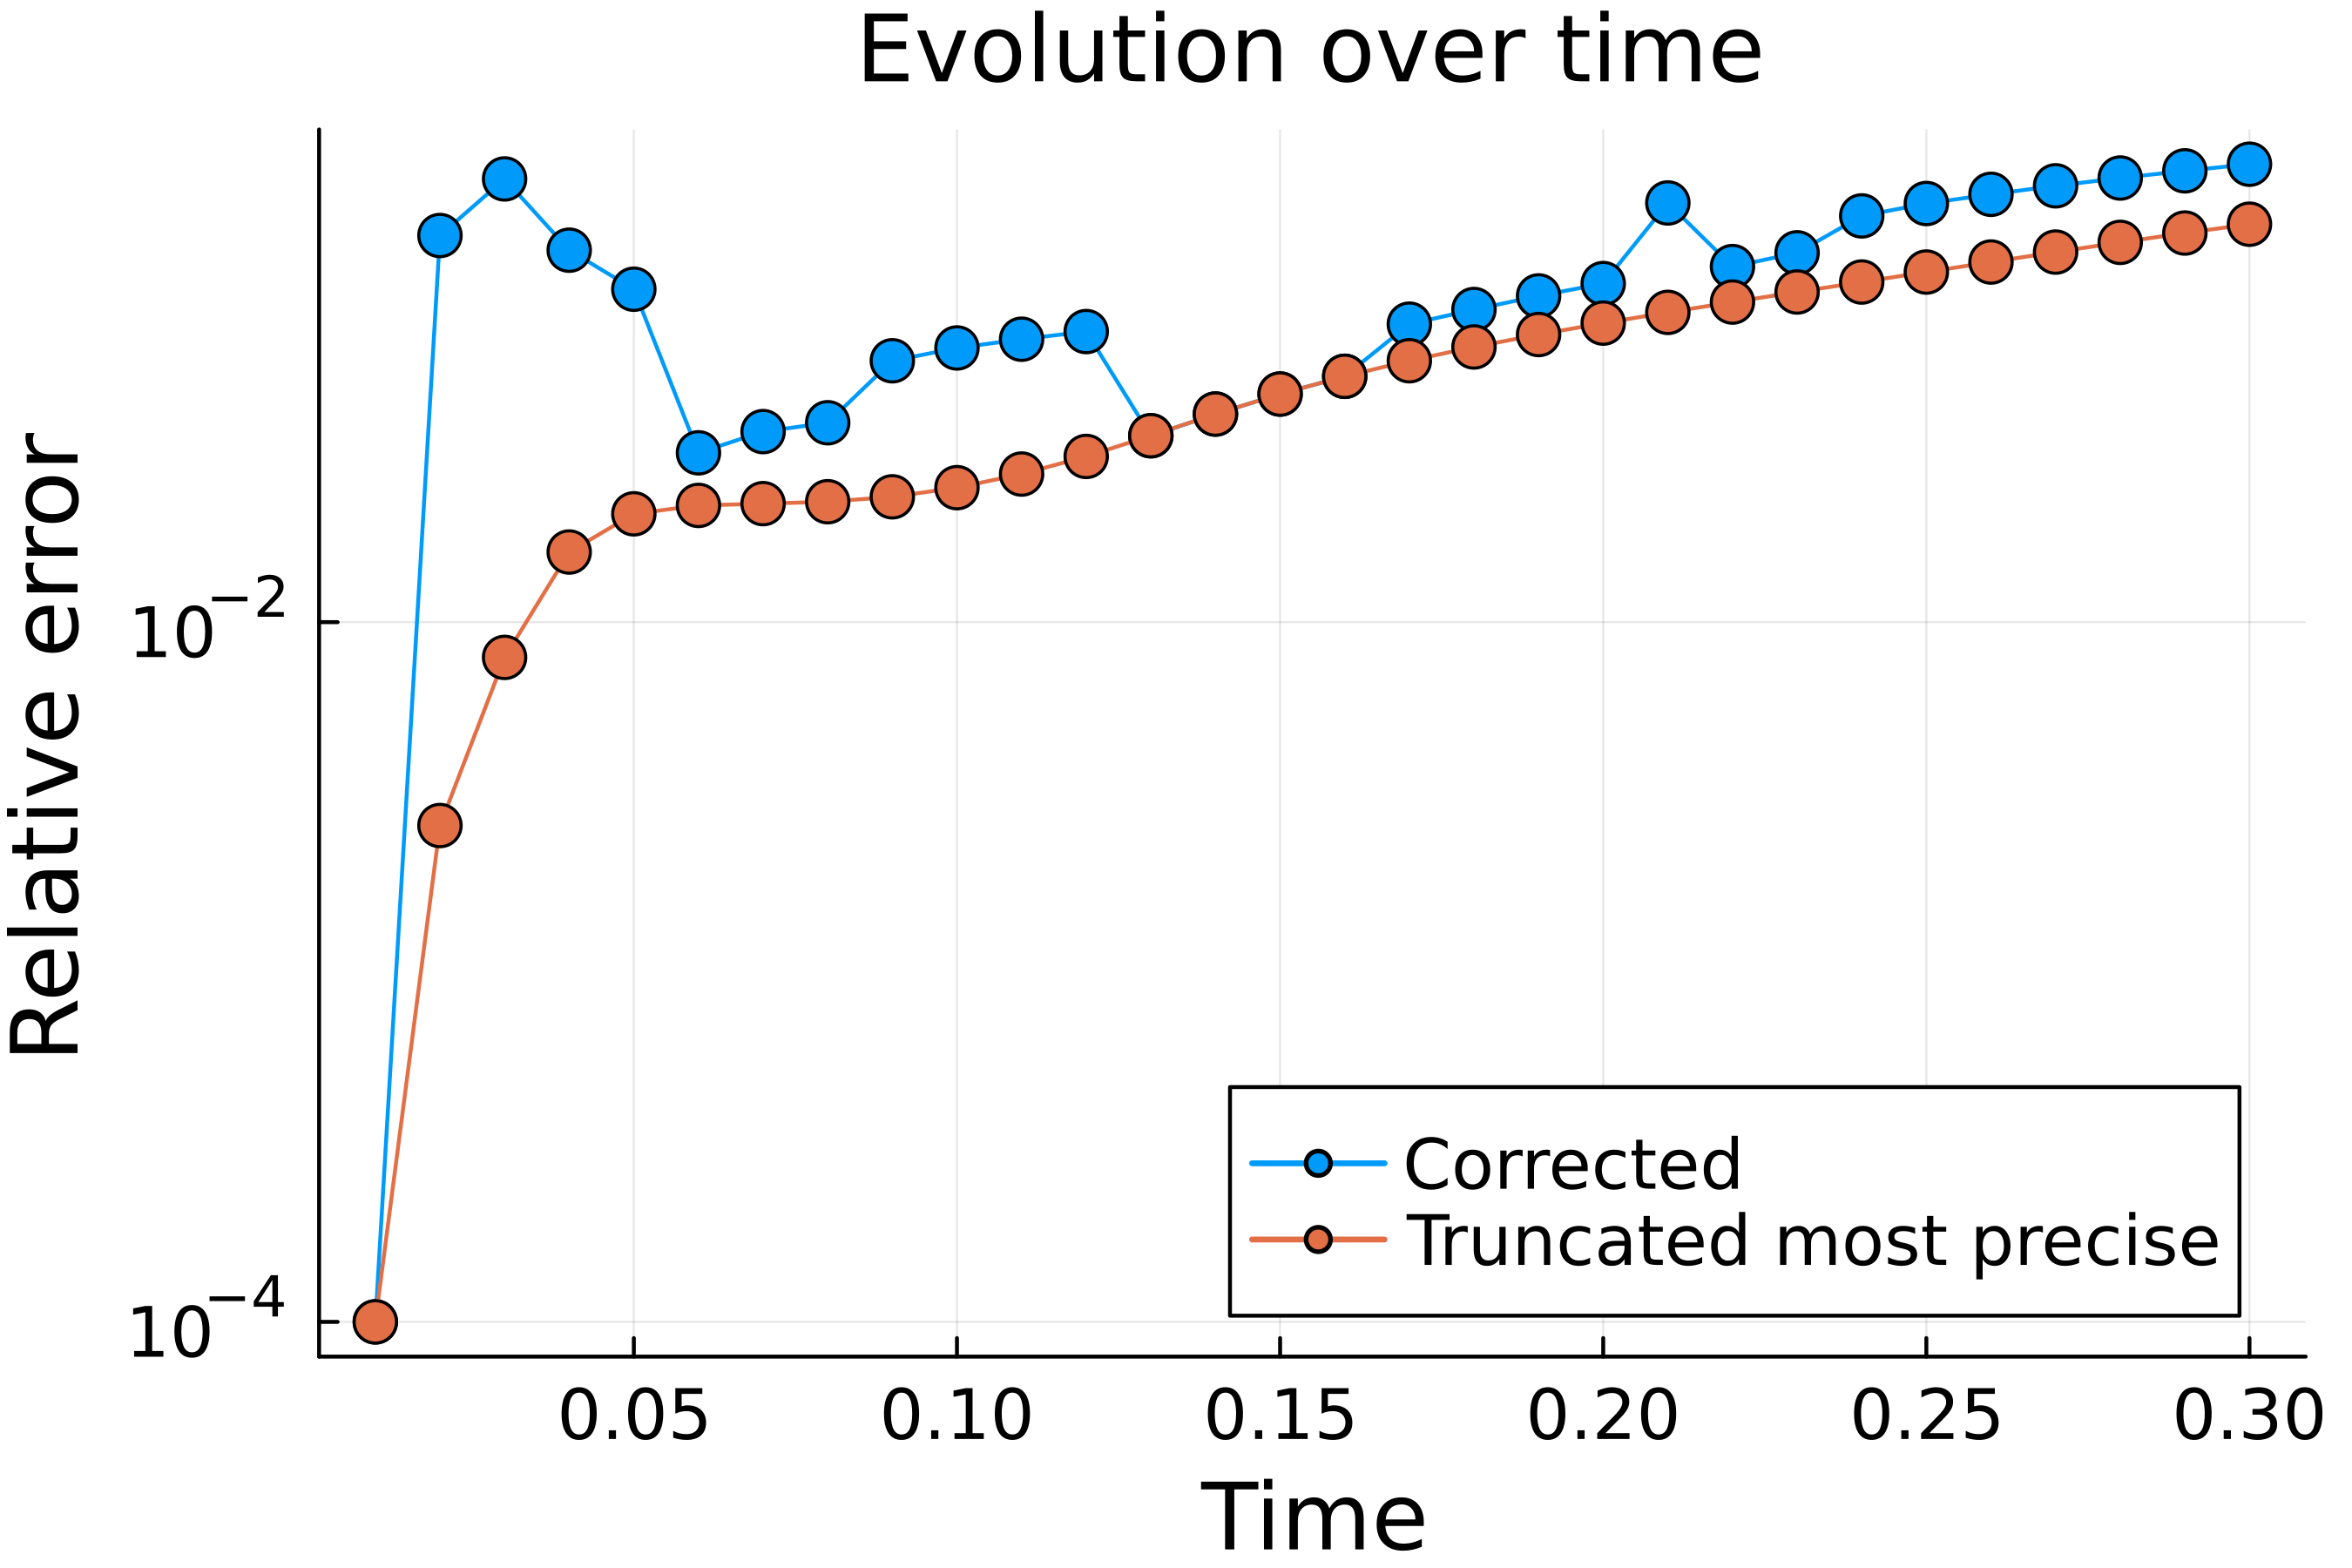

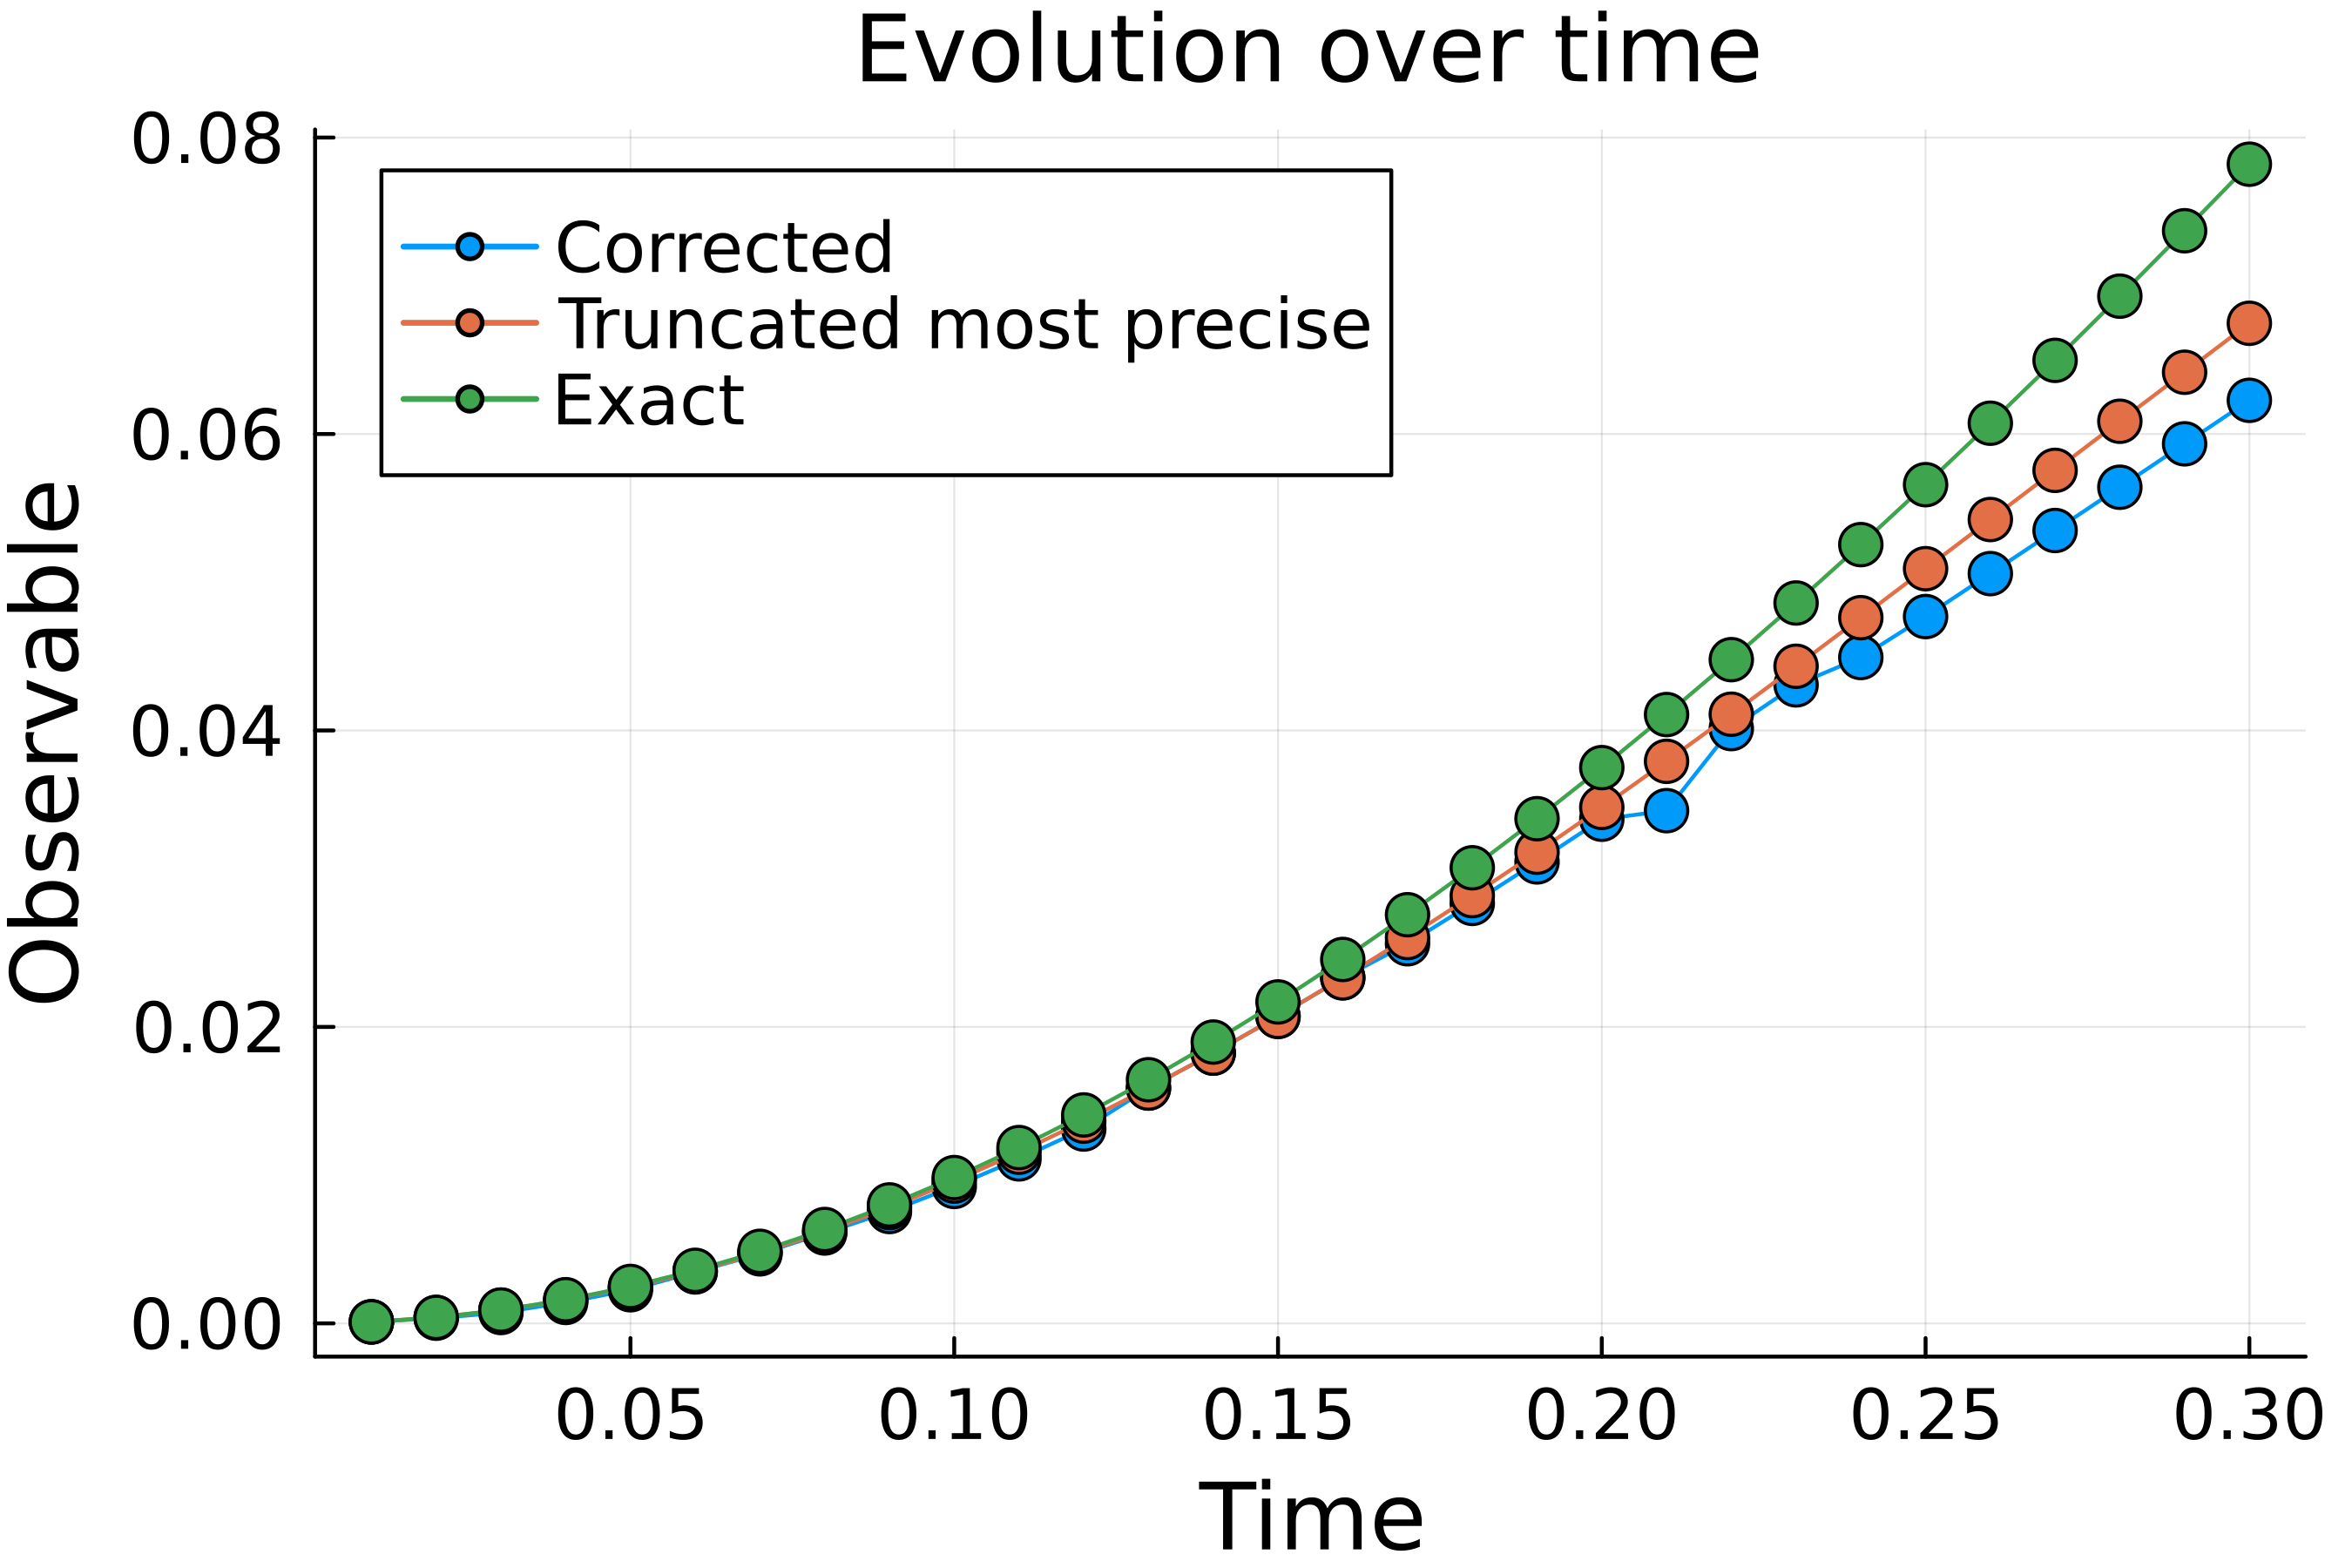

In [32]:
model = "TFIM"
nq = 30
nl = 30
theta = 0.01im
θ = theta

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 12
max_weight = 12
# range -10 to -20 is already generated for nl=20, nq=30
#trunc_coeffs = 2.0 .^ (-10:-1:-20)
trunc_coeffs = 2.0 .^ (-11:-1:-16) # for nq=8, nl=4, tstep=0.01
tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\textrm{time}", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$",guidefontsize=16,
tickfontsize=12,
legendfontsize=12,titlefontsize = 16, ms = 6, dpi= 450)

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0) # nq, Jx,Jy, h
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
terms_nbrs = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation, terms_nbr = run_or_read("TFIM",circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation[expectation .== 0] .= 1e-16
    
    #plot last 5 values
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
    push!(terms_nbrs, terms_nbr)
end
#plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
savefig("presentation/$fn.png")	
#delete the first n values of every nested vector in expvals and terms_nbrs
zte_exp(expvals, terms_nbrs, time; exact_expvals=zz, fn=fn);